### Benchmarking based on PASS00589 datasets from peptidealtas database

####  A profiling standard data set consists of 12 nonhuman proteins spiked into a constant human background[HEK293], including eight different sample groups with known concentrations of spiked-in proteins in three master mixs. A Q Exactive Orbitrap MS was used to analyze three replicates of each sample group

#### A fasta database of the human protein sequences merged with the spiked-in proteins sequence use used for searching. A false discoving rate of 0.01 was set as a threshold for peptide identifications and protein-level identifications

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../datasets/PASS00589'
setwd(data_folder)

### Number of protein quantified

#### quantms quantified more proteins than DOI: 10.1093/bib/bbx054. And it basically same as another original research DOI: 10.1074/mcp.M114.044305.  

In [4]:
quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
print(len(set(quantms['ProteinName'])))
quantms.head()


3847


,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity,Reference
0,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample1,1,1,8488644.0,B_D140314_SGSDSsample1_R01_MSG_T0.mzML
1,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample4,4,10,2937769.0,B_D140314_SGSDSsample4_R01_MSG_T0.mzML
2,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample5,5,14,313403.4,B_D140314_SGSDSsample5_R02_MSG_T0.mzML
3,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample6,6,16,8892265.0,B_D140314_SGSDSsample6_R01_MSG_T0.mzML
4,sp|Q86U42|PABP2_HUMAN,.(Acetyl)AAAAAAAAAAGAAGGR,2,NaN,0,L,Sample7,7,19,1741688.0,B_D140314_SGSDSsample7_R01_MSG_T0.mzML


#### overlap of proteins quantified. The most of proteins quantified are shared.

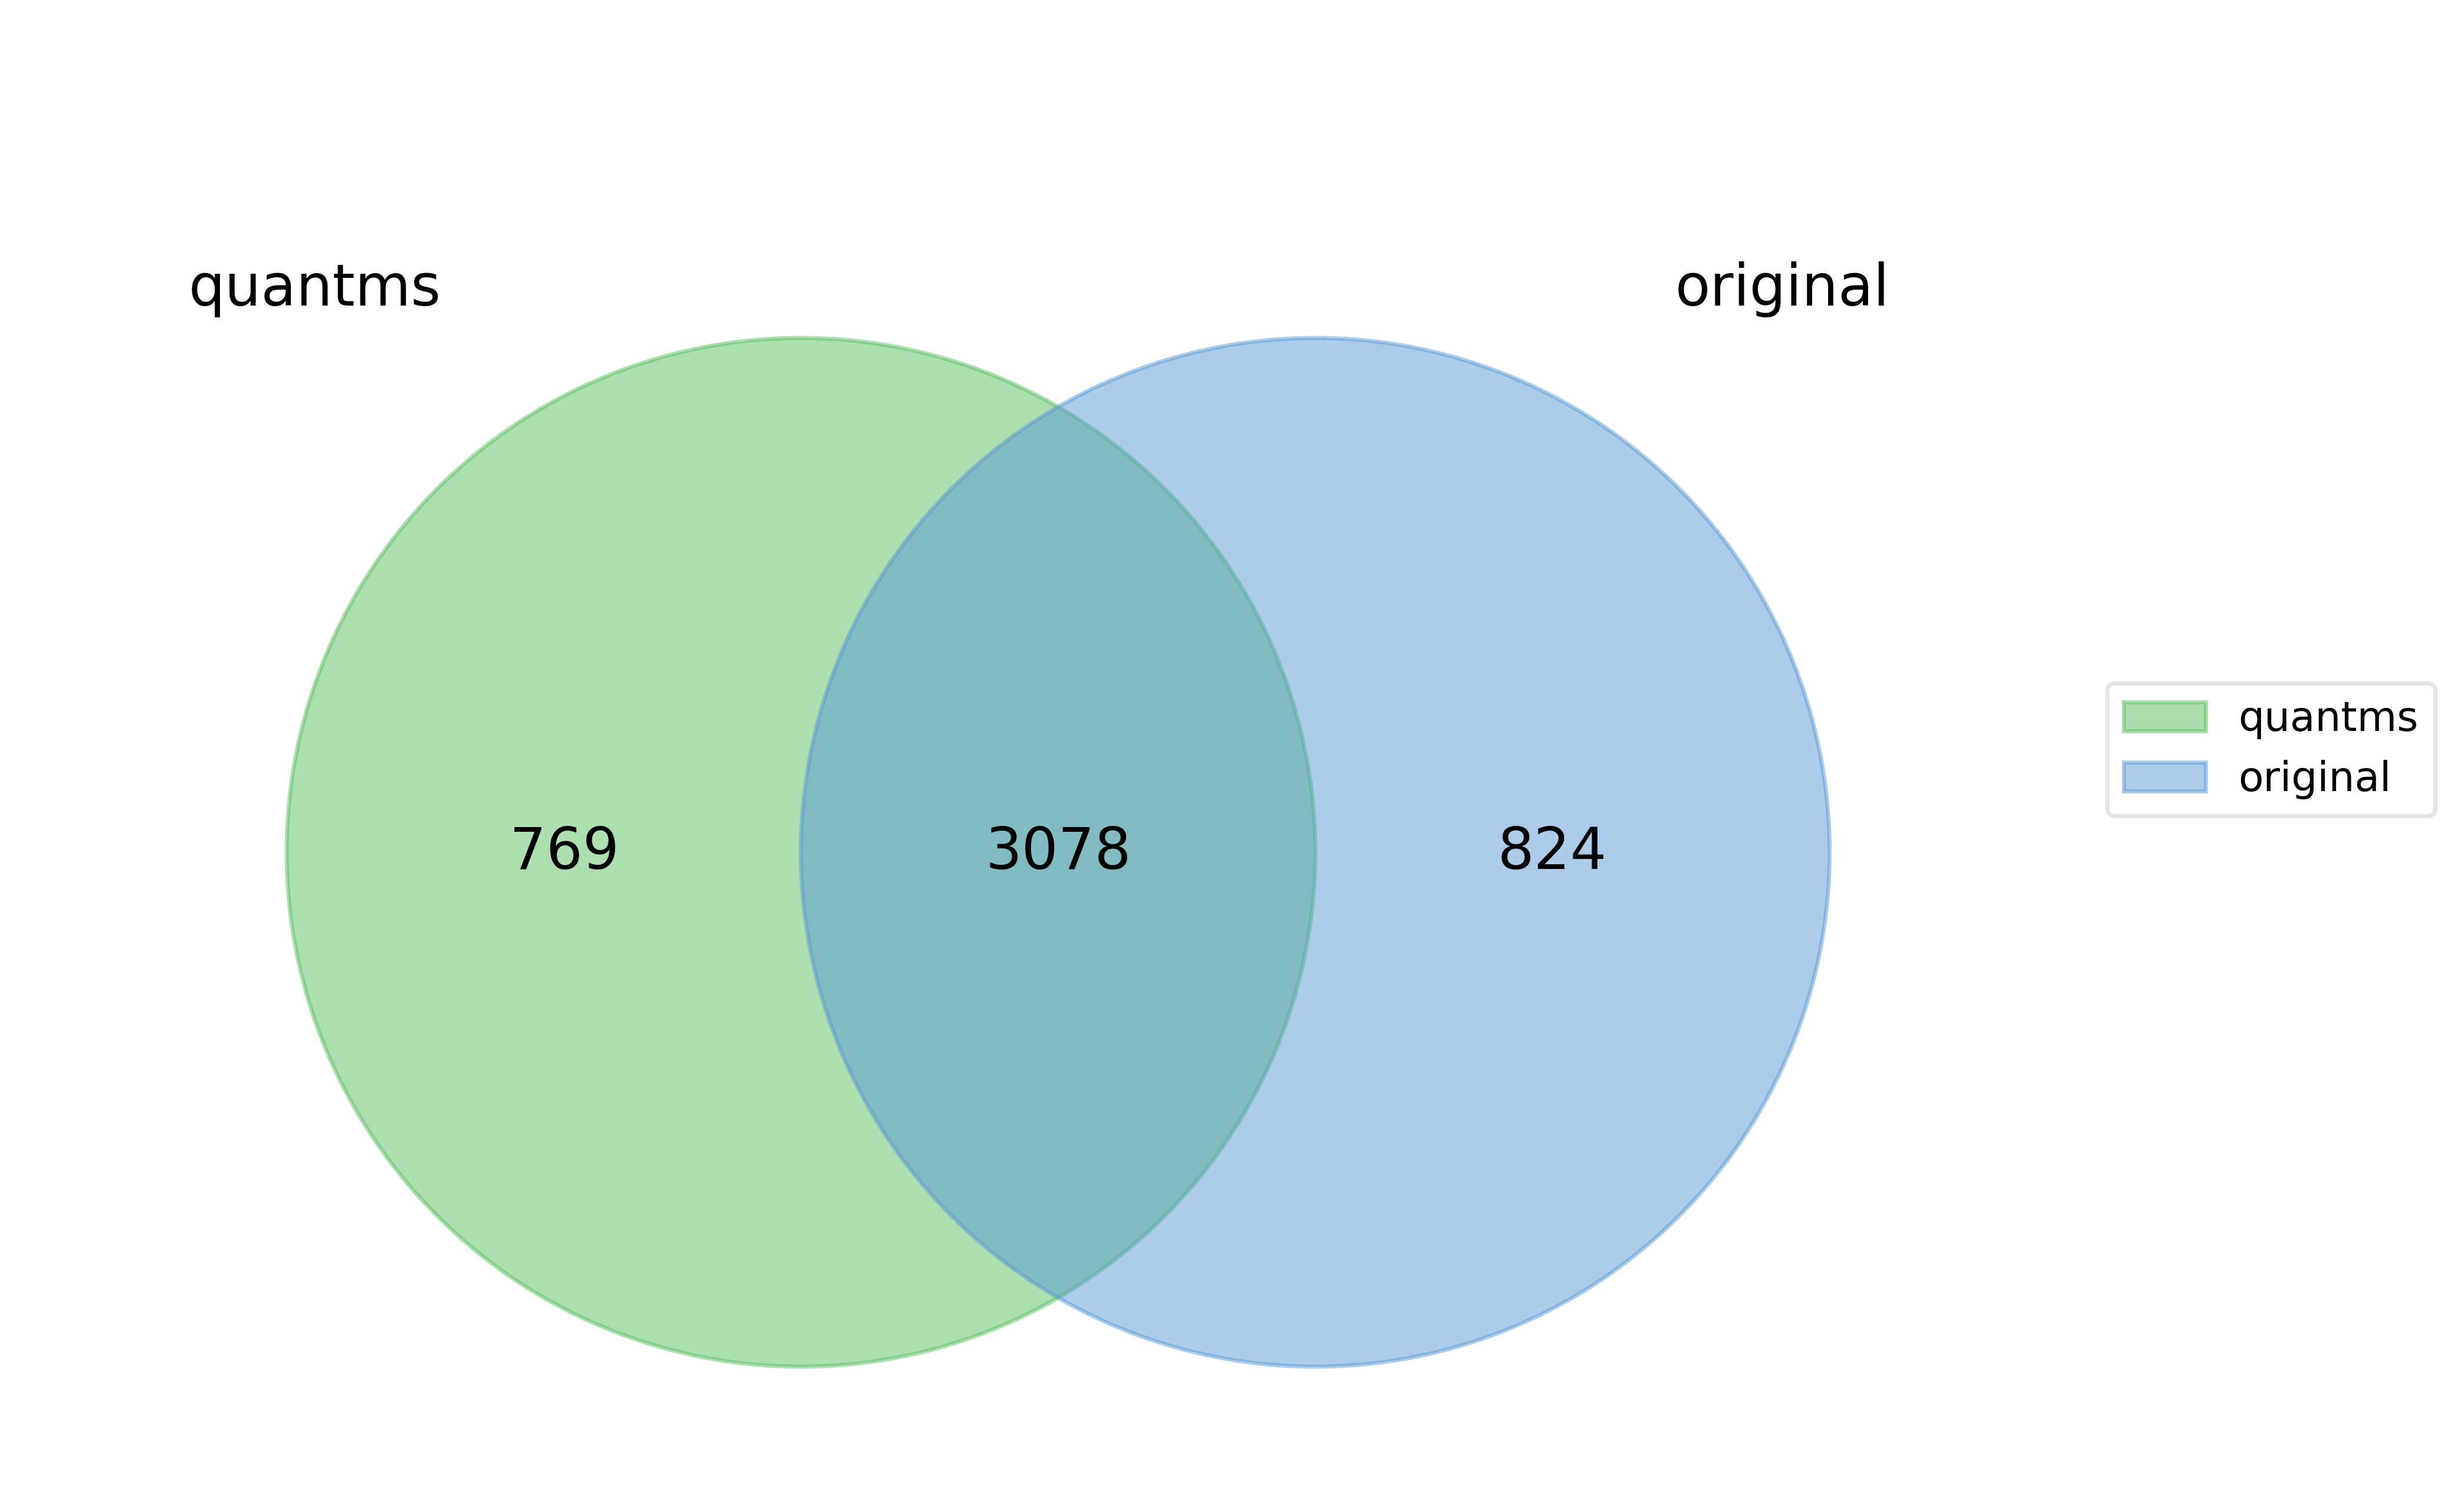

In [5]:
from pyvenn import venn
quantms['P1'] = quantms.apply(lambda x: ";".join(x['ProteinName'].split("|")[1::2]), axis=1)

original = pd.read_excel("supp_M114.044305_mcp.M114.044305-3.xlsx", header=0, sheet_name= "Shotgun-RAW")
original = original.dropna(how="any")
original = original[-original['Proteins'].str.contains("CON_")]
original.head()
labels = venn.get_labels([set(quantms['P1']), set(original['Proteins'])], fill=['number'])
fig, ax = venn.venn2(labels, names=['quantms', 'original'], dpi=500)
plt.show()

### The total number of spiked-in proteins detected is 12 (12). All spiked-in proteins are quantified. The number of proteins detected is different across conditions. Main reason may be difference of concentrations of the proteins. 

12


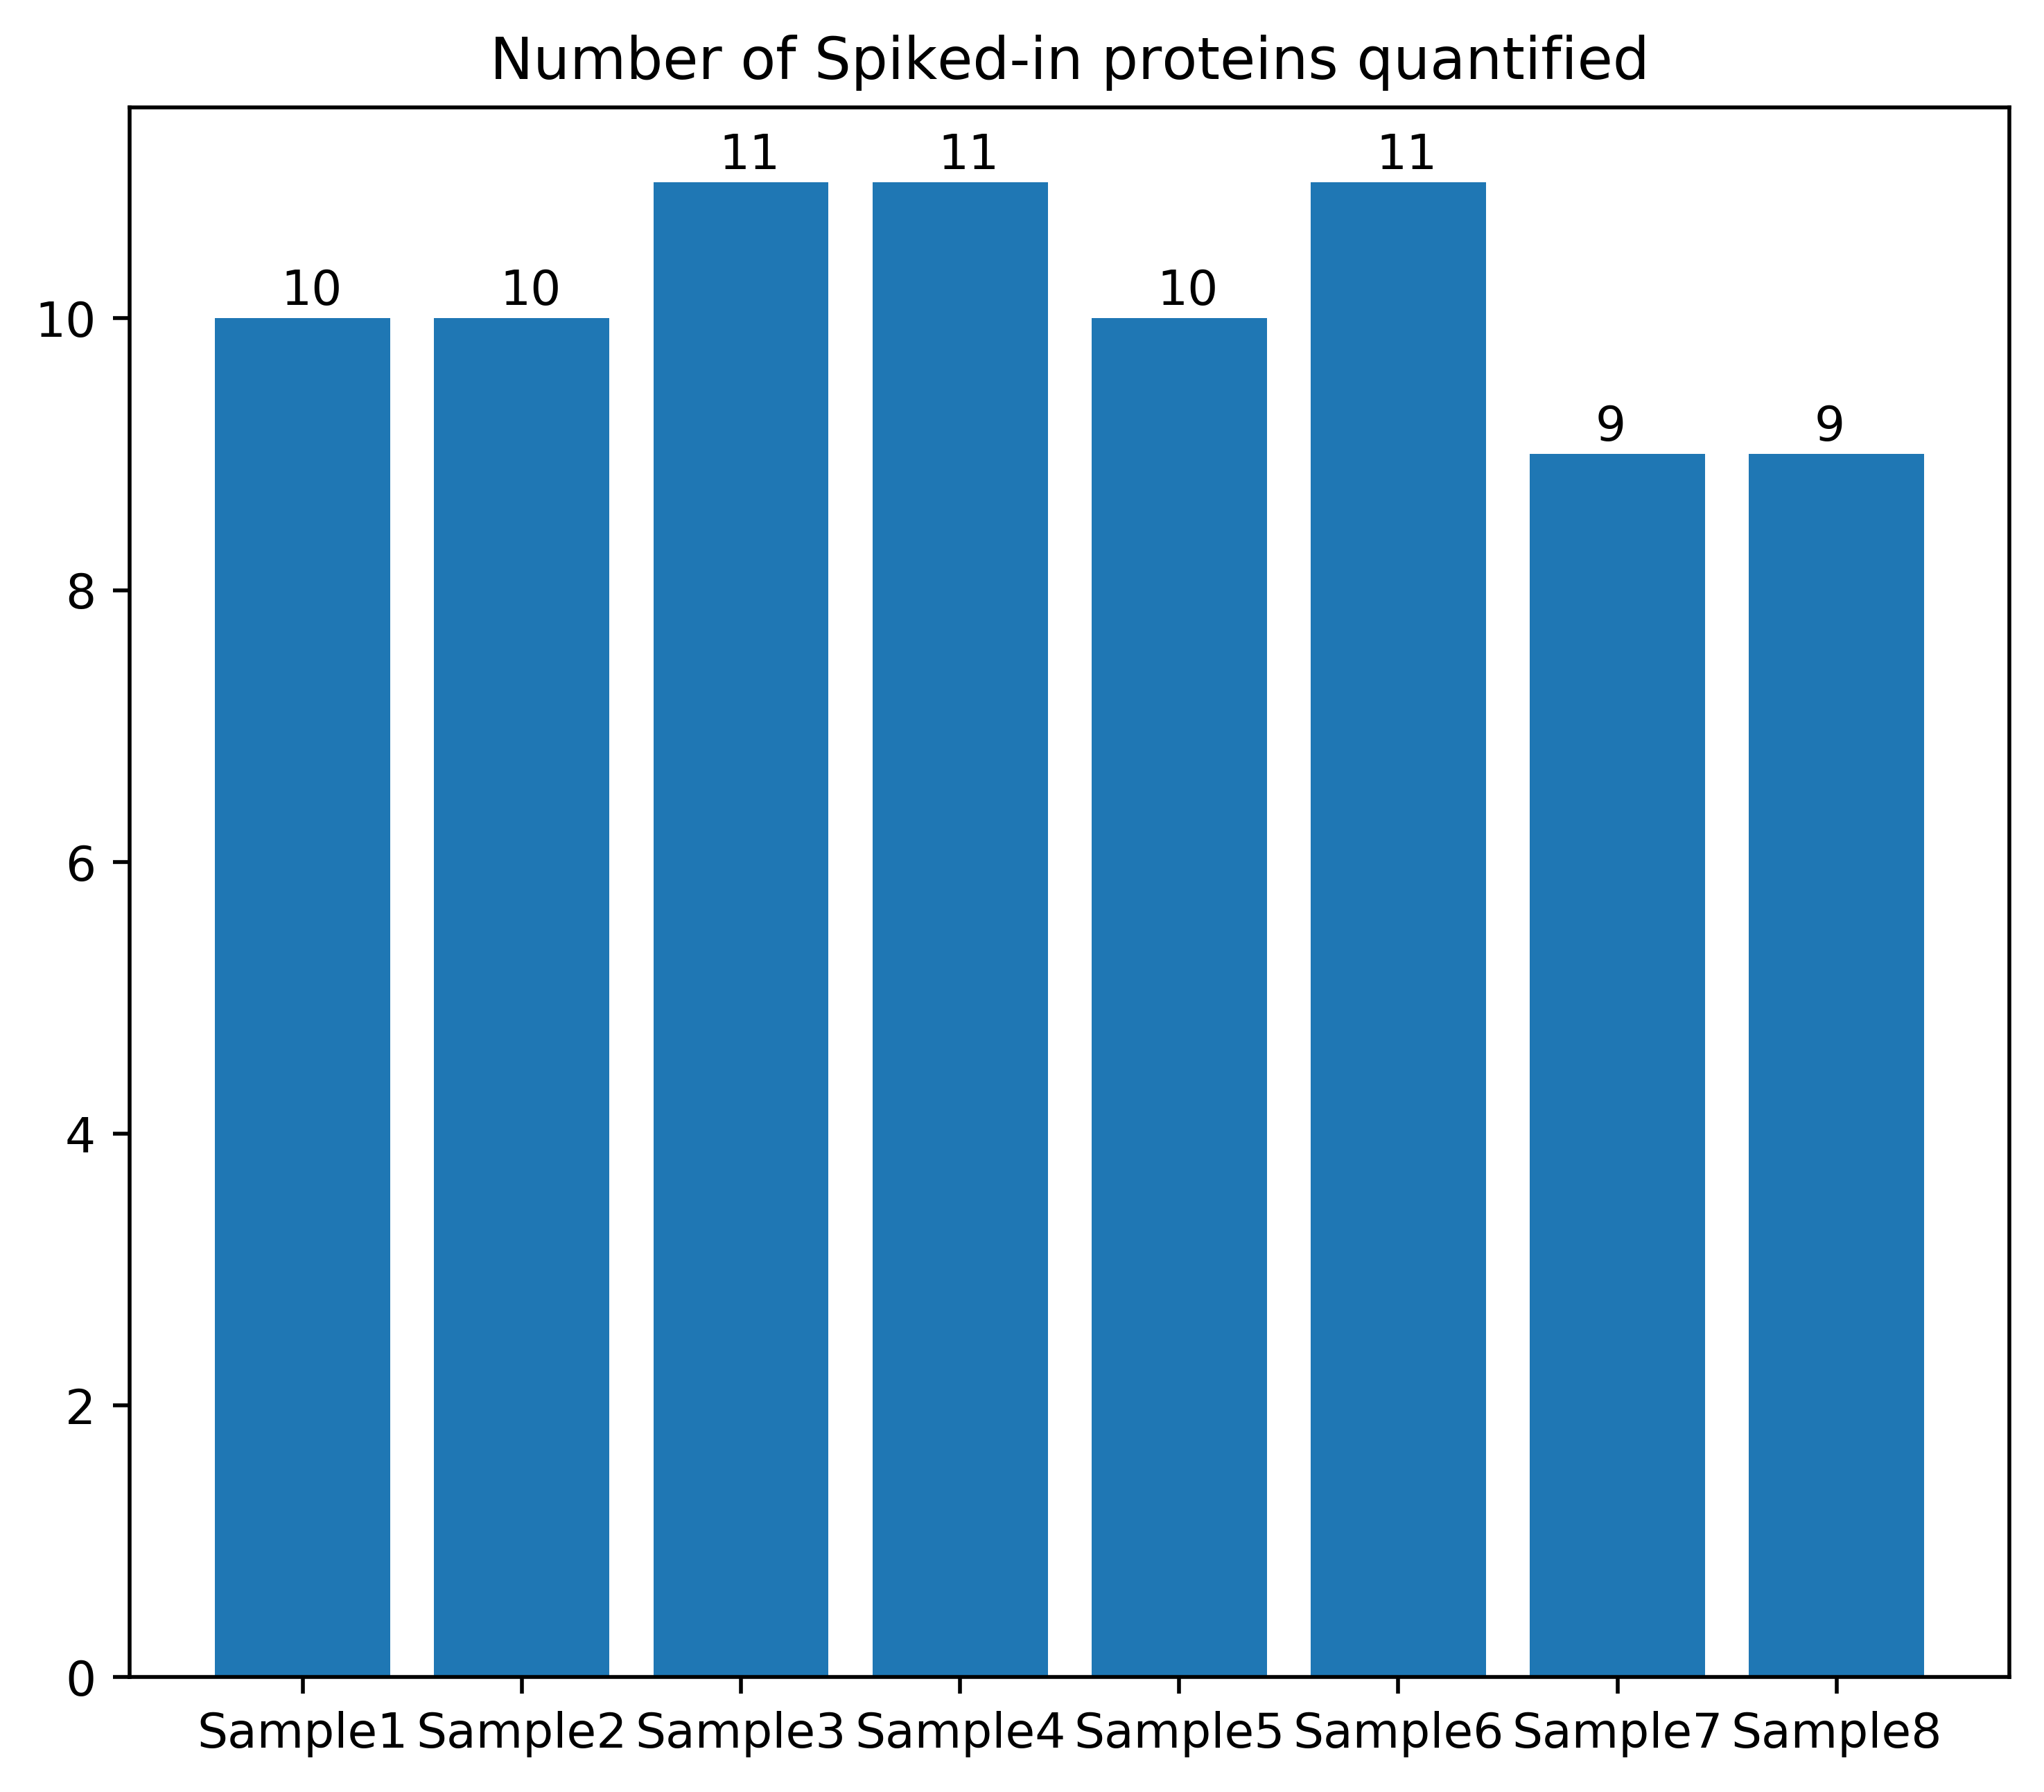

In [6]:
number_of_ups1 = dict()
print(len(set(quantms[-quantms['ProteinName'].str.contains("HUMAN")]['ProteinName'])))
for condition in np.unique(quantms['Condition']):
    number_of_ups1[condition] = len((set(quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition), 'ProteinName'])))

plt.figure(figsize=(7,6), dpi=500)
num = []
label = []
for key, value in sorted(number_of_ups1.items(), key=lambda item: int(item[0].replace("Sample",""))):
    num.append(value)
    label.append(key.replace(" ", ""))
for x, y in zip(range(8), num):
    plt.text(x-0.1, y+0.1, y)

plt.bar(range(8), num)
plt.title("Number of Spiked-in proteins quantified")
plt.xticks(range(8),label)
plt.show()

### Assess missing value

#### Proportion of missing values in the detected spiked-in proteins is 7.4% from quantms. Proportion of missing values is 20.5% from result  10.1074/mcp.M114.044305.

In [7]:
missing_values_spiked = 0
total = 0
for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        total += 3
        if len(msruns) < 3:
            missing_values_spiked += (3 - len(msruns))
            
print(missing_values_spiked / total)

0.07407407407407407


In [9]:
Master_Mix1 = ['P02754', 'P80025', 'P00921', 'P00366', 'P02662']
Master_Mix2 = ['P61823', 'P02789', 'P12799', 'P02676', 'P02672']
Master_Mix3 = ['P02666', 'P68082']
missing_values_spiked = 0
expected_num = 0
total = Master_Mix1 + Master_Mix2 + Master_Mix3
original = pd.read_excel("oroginal_result.xlsx", header=0, sheet_name="Shotgun-MS-normalized datatable")
original_spiked = original[original['Protein'].isin(total)]
original_spiked.head(10)
for protein in np.unique(original_spiked['Protein']):
    t = original_spiked[original_spiked['Protein'] == protein]
    t = t.iloc[:, 3:]
    for i in range(8):
        spec_t = t.iloc[:, i * 3: 3 + i * 3]
        spec_t = spec_t.dropna(axis=1, how="all")
        if len(spec_t) == 0:
            continue
        else:
            expected_num += 3
            missing_values_spiked += (3 - spec_t.shape[1])
            
print(missing_values_spiked / expected_num)

0.2048611111111111


#### Proportion of missing value in background proteins is 20%. It is higher than other workflow reported by DOI: 10.1093/bib/bbx054 . Main reason may be that quantms quantified more proteins.  But our result is better than original result reported by 10.1074/mcp.M114.044305: 21.4%

In [10]:
missing_values_background = 0
total = 0
for condition in np.unique(quantms['Condition']):
    quant_condition = quantms.loc[(quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        total += 3
        if len(msruns) < 3:
            missing_values_background += (3 - len(msruns))
            
print(missing_values_background / total)

0.19971903535471786


In [12]:
missing_values_background = 0
expected_num = 0
total = Master_Mix1 + Master_Mix2 + Master_Mix3
original_background= original[-original['Protein'].isin(total)]
original_background.head(10)
for protein in np.unique(original_background['Protein']):
    t = original_background[original_background['Protein'] == protein]
    t = t.iloc[:, 3:]
    for i in range(8):
        spec_t = t.iloc[:, i * 3: 3 + i * 3]
        spec_t = spec_t.dropna(axis=1, how="all")
        if len(spec_t) == 0:
            continue
        else:
            expected_num += 3
            missing_values_background += (3 - spec_t.shape[1])
            
print(missing_values_background / expected_num)

0.21371206357257588


### Reproducibility between Analytical Replicate before msstats process

#### Testing each concentration in triplicate allowed us to calculate a coefficient of variation (CV) of peptide/protein intensities to asses signal extraction reproducibility annd workflow consistency

#### Calculate the metrics before msstats process to assess quantms. Of course is it necessary to calculate this metric after msstats processing?. Ignoring missing proteins at the same time.

#### CV = protein mean intensity within replicates / corresponding std. For the peptide intensity, abundances are summed over all charge states. Then Protein abundance will be computed from peptide abundances based on median ???. CV is calculated separately in background proteins and UPS1 proteins.

#### don’t understand how the mean CV of 17.8% for all given in the article is calculated. Big difference in results. Our CV does not look good.

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


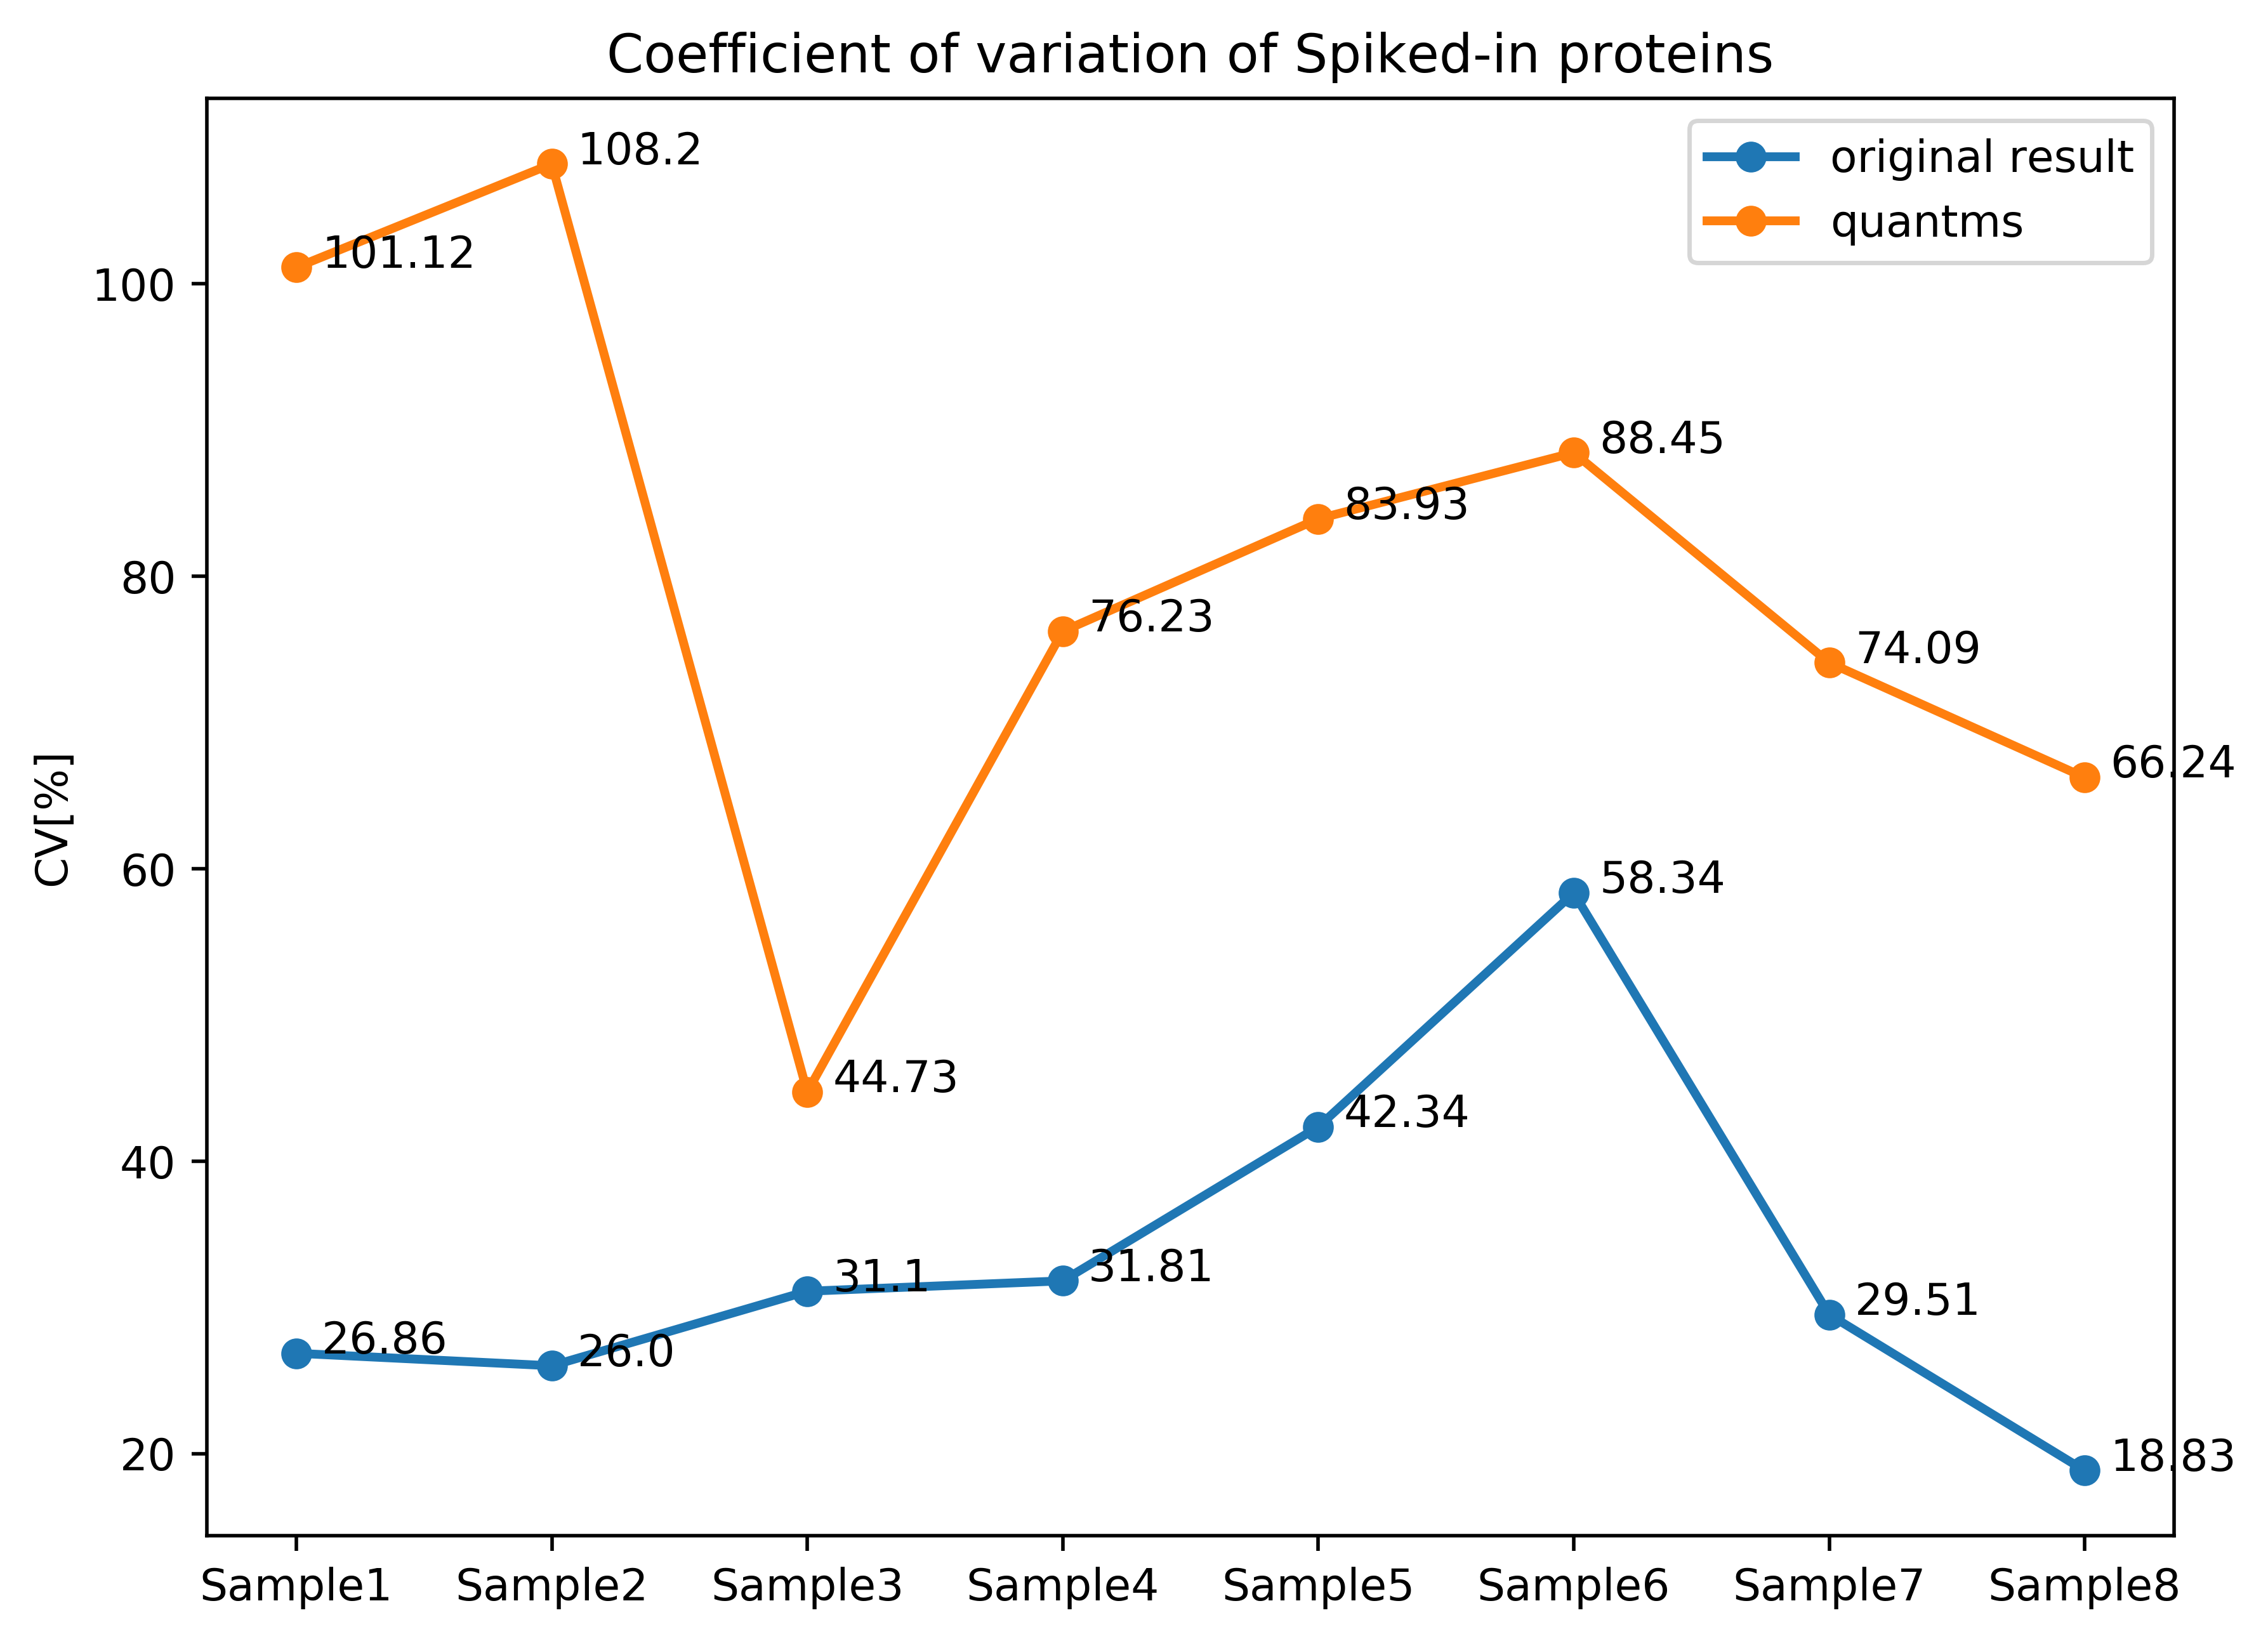

In [21]:
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
for Protein in np.unique(original_spiked['Protein']):
    spec_protein = original_spiked.loc[original_spiked['Protein'] == Protein]
            
    # summarized protein intensity in a technical replicate
    for i in range(1, 9):
        p_condition = spec_protein[['Sample' + str(i) + "Rep1", 'Sample' + str(i) + "Rep2", 'Sample' + str(i) + "Rep3"]]
        t = p_condition.dropna(axis=1, how="all")

        # proteins were filtered out if not quantified in all replicates
        if t.shape[1]<3:
            continue

        tech_intensity = [] 
        pep_intensity = {'Rep1':[], 'Rep2':[], 'Rep3':[]}
        for pep in np.unique(spec_protein['Peptide']):
            pep_intensity['Rep1'].append(np.sum(spec_protein[spec_protein['Peptide'] == pep]['Sample' + str(i) + 'Rep1']))
            pep_intensity['Rep2'].append(np.sum(spec_protein[spec_protein['Peptide'] == pep]['Sample' + str(i) + 'Rep2']))
            pep_intensity['Rep3'].append(np.sum(spec_protein[spec_protein['Peptide'] == pep]['Sample' + str(i) + 'Rep3']))
        tech_intensity.append(np.median(pep_intensity['Rep1']))
        tech_intensity.append(np.median(pep_intensity['Rep2']))
        tech_intensity.append(np.median(pep_intensity['Rep3']))

        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        n_data = n_data.append({'ProteinName':Protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': "Sample" + str(i), "CV[%]": 100 * (std / mean)}, ignore_index=True)
            
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace("Sample","")))
cvs = []
xticks = []
plt.figure(figsize=(8,6), dpi=500)
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    
plt.plot(range(8), cvs, linewidth=2, marker='o', markersize=6)
for i in range(8):
    plt.text(i+0.1, cvs[i], round(cvs[i], 2))


# quantms result
n_data = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
for condition in np.unique(quantms['Condition']):
    if len(quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition)]) < 3:
        continue
    quant_condition = quantms.loc[(-quantms['ProteinName'].str.contains("HUMAN")) & (quantms['Condition'] == condition)]
    for protein in np.unique(quant_condition['ProteinName']):
        msruns = np.unique(quant_condition[quant_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            t = quant_condition[(quant_condition['ProteinName'] == protein) & ((quant_condition['Run'] == run))]
            pep_intensity = []
            for pep in np.unique(t['PeptideSequence']):
                pep_intensity.append(np.sum(t[t['PeptideSequence'] == pep]['Intensity']))
                
            tech_intensity.append(np.median(pep_intensity))
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        n_data = n_data.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean)}, ignore_index=True)

# calcualte average CV in UPS1 proteins without missing value
cvs = []
xticks = []
# plt.figure(figsize=(8,6), dpi=500)
conditions = np.unique(n_data["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace("Sample","")))
for condition in conditions:
    cvs.append(np.mean(n_data[n_data['Condition'] == condition]["CV[%]"]))
    xticks.append(condition)
    
plt.plot(range(8), cvs, linewidth=2, marker='o', markersize=6)
plt.xticks(range(8), xticks)
for i in range(8):
    plt.text(i+0.1, cvs[i], round(cvs[i], 2))
plt.ylabel('CV[%]')
plt.title('Coefficient of variation of Spiked-in proteins')
plt.legend(['original result', 'quantms'])
plt.show()


In [23]:
original_background_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]", "Hue"])
for Protein in np.unique(original_background['Protein']):
    spec_protein = original_background.loc[original_background['Protein'] == Protein]
            
    # summarized protein intensity in a technical replicate
    for i in range(1, 9):
        p_condition = spec_protein[['Sample' + str(i) + "Rep1", 'Sample' + str(i) + "Rep2", 'Sample' + str(i) + "Rep3"]]
        t = p_condition.dropna(axis=1, how="all")

        # proteins were filtered out if not quantified in all replicates
        if t.shape[1]<3:
            continue
            
        tech_intensity = []
        pep_intensity = {'Rep1':[], 'Rep2':[], 'Rep3':[]}
        for pep in np.unique(spec_protein['Peptide']):
            pep_intensity['Rep1'].append(np.sum(spec_protein[spec_protein['Peptide'] == pep]['Sample' + str(i) + 'Rep1']))
            pep_intensity['Rep2'].append(np.sum(spec_protein[spec_protein['Peptide'] == pep]['Sample' + str(i) + 'Rep2']))
            pep_intensity['Rep3'].append(np.sum(spec_protein[spec_protein['Peptide'] == pep]['Sample' + str(i) + 'Rep3']))
        tech_intensity.append(np.median(pep_intensity['Rep1']))
        tech_intensity.append(np.median(pep_intensity['Rep2']))
        tech_intensity.append(np.median(pep_intensity['Rep3']))

        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        original_background_cv = original_background_cv.append({'ProteinName':Protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': "Sample" + str(i), "CV[%]": 100 * (std / mean), "Hue": "Roland Bruderer et al"}, ignore_index=True)
            
conditions = np.unique(original_background_cv["Condition"])
conditions = sorted(conditions, key= lambda x: float(x.replace("Sample","")))
for condition in conditions:
    print(condition + " mean cv: %f" %(np.mean(original_background_cv[original_background_cv['Condition'] == condition]["CV[%]"])))


C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


Sample1 mean cv: 53.045000
Sample2 mean cv: 52.628499
Sample3 mean cv: 54.982621
Sample4 mean cv: 52.305169
Sample5 mean cv: 52.508806
Sample6 mean cv: 55.528692
Sample7 mean cv: 52.078120
Sample8 mean cv: 53.478175


Sample1 mean cv: 56.785649
Sample2 mean cv: 65.158158
Sample3 mean cv: 42.615329
Sample4 mean cv: 60.061290
Sample5 mean cv: 59.940003
Sample6 mean cv: 63.850376
Sample7 mean cv: 45.483938
Sample8 mean cv: 54.885319


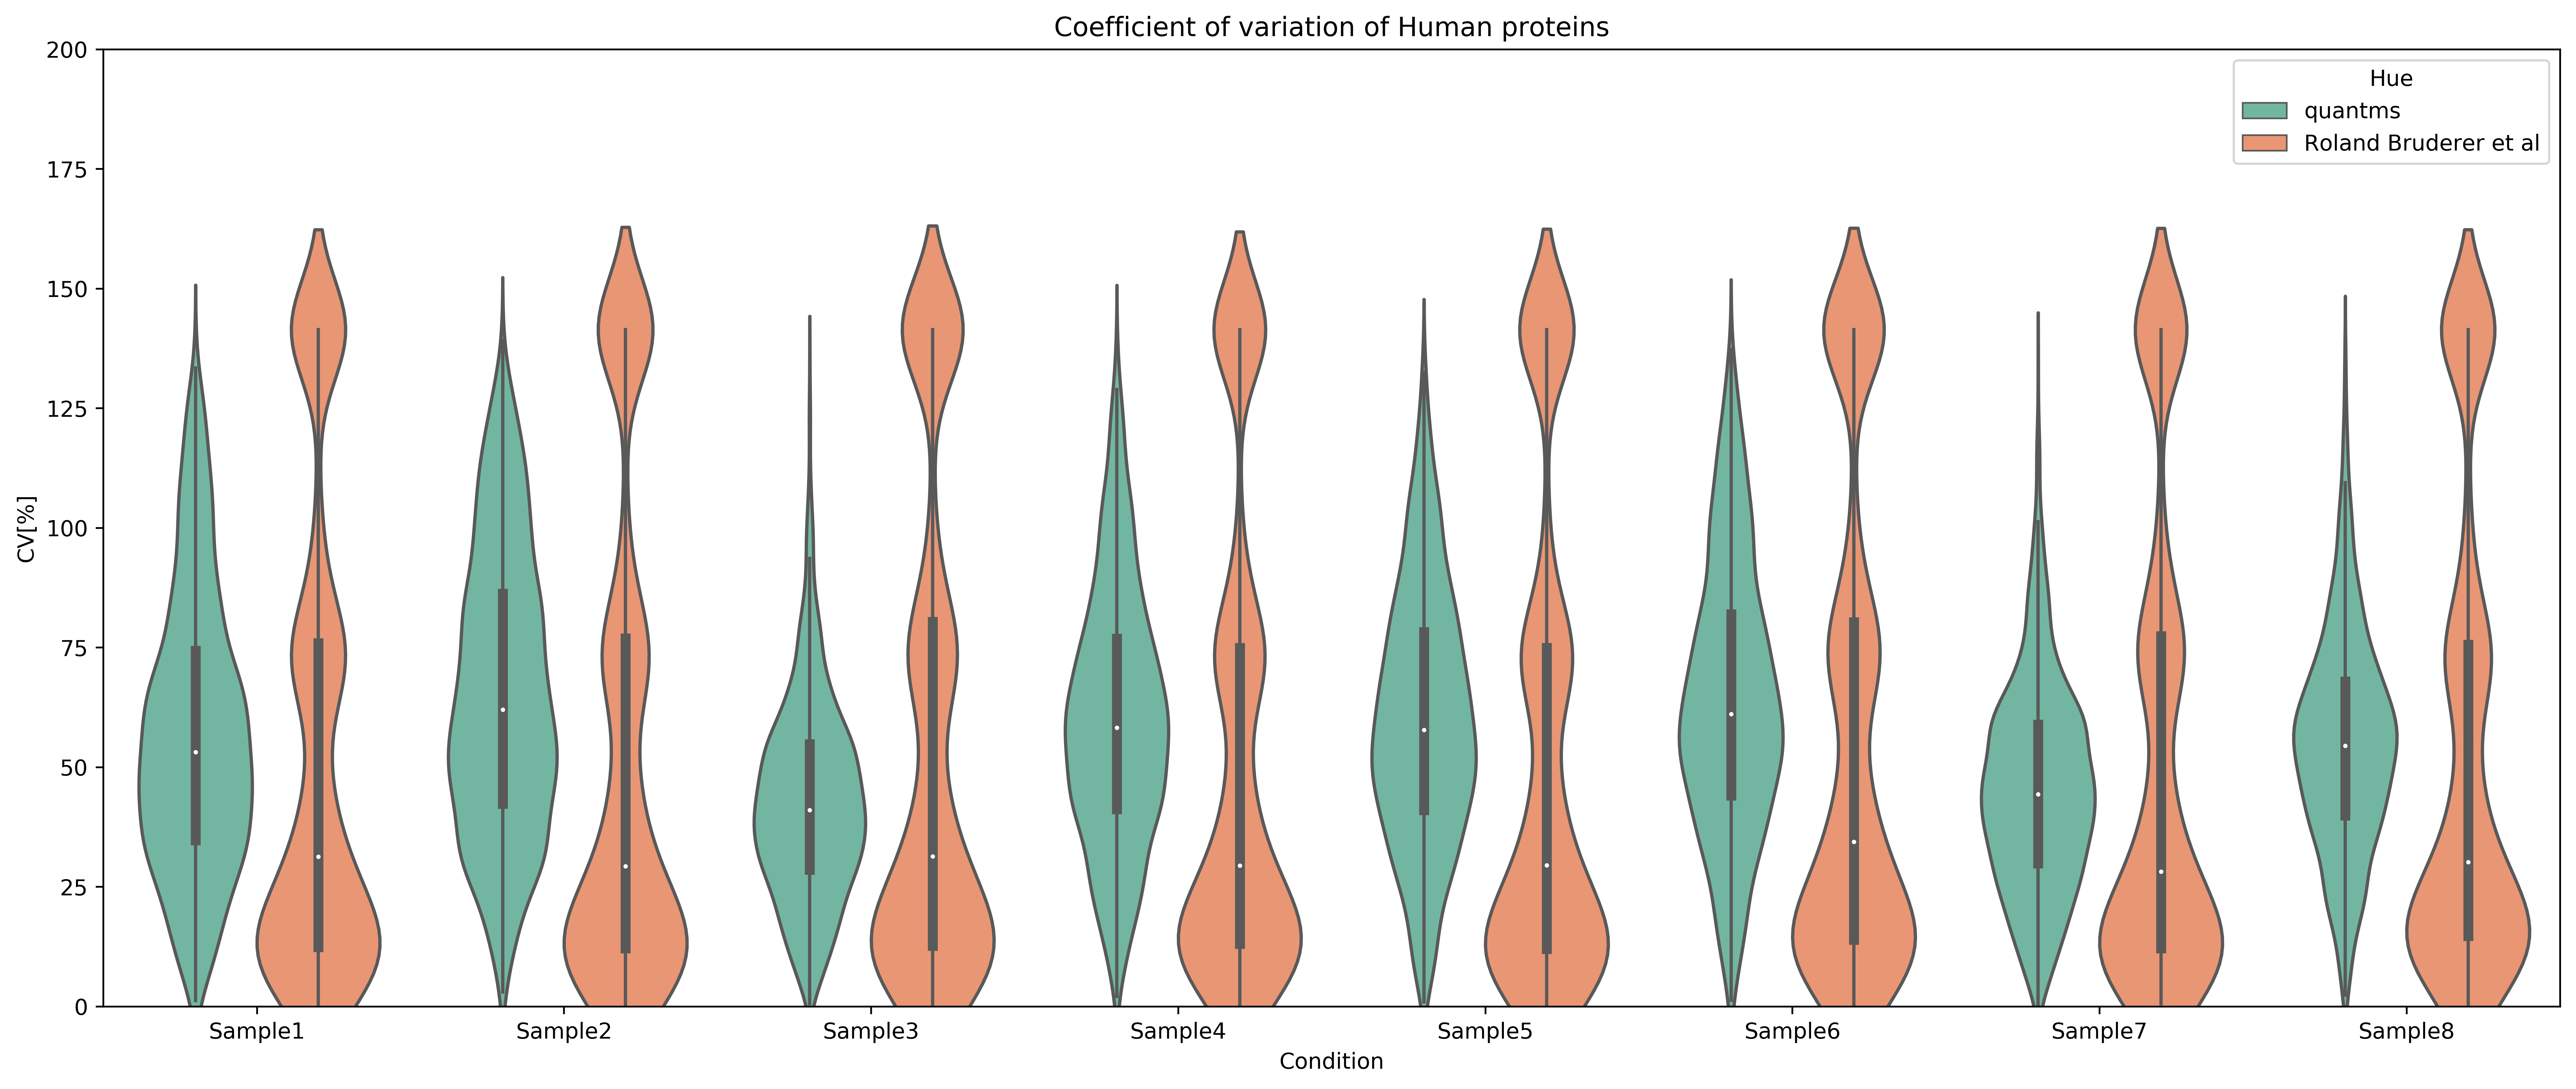

In [27]:
quantms_background_cv = pd.DataFrame(None,columns = ['ProteinName','TechRep1','TechRep2', 'TechRep3', 'Condition', "CV[%]"])
quantms_background = quantms[quantms['ProteinName'].str.contains("HUMAN")]
for condition in np.unique(quantms_background['Condition']):
    quantms_background_condition = quantms_background.loc[quantms_background['Condition'] == condition]
    cvs = []
    for protein in np.unique(quantms_background_condition['ProteinName']):
        msruns = np.unique(quantms_background_condition[quantms_background_condition['ProteinName'] == protein]['Run'])
        
        # proteins were filtered out if not quantified in all replicates
        if len(msruns) < 3:
            continue
            
        tech_intensity = []    
        # summarized protein intensity in a technical replicate
        for run in msruns:
            t = quantms_background_condition[(quantms_background_condition['ProteinName'] == protein) & ((quantms_background_condition['Run'] == run))]
            
            pep_intensity = []
            for pep in np.unique(t['PeptideSequence']):
                pep_intensity.append(np.sum(t[t['PeptideSequence'] == pep]['Intensity']))
            tech_intensity.append(np.median(pep_intensity))
            
        mean = np.mean(tech_intensity)
        std = np.std(tech_intensity)
        cvs.append(100 * (std / mean))
        quantms_background_cv = quantms_background_cv.append({'ProteinName':protein,'TechRep1':tech_intensity[0], 
                       'TechRep2': tech_intensity[1], 'TechRep3': tech_intensity[2], 
                       'Condition': condition, "CV[%]": 100 * (std / mean), "Hue": "quantms"}, ignore_index=True)
        
    print(condition + " mean cv: %f" %(np.mean(cvs)))
    
quantms_background_cv = quantms_background_cv.append(original_background_cv)

plt.figure(figsize=(20,8), dpi=500)
plt.ylim(0, 200)
plt.title("Coefficient of variation of Human proteins")
sns.violinplot(x = "Condition", y="CV[%]", data=quantms_background_cv, scale= "count", palette="Set2", hue="Hue",
               order=['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5','Sample6', 'Sample7', 'Sample8'])

plt.show()

### QCplots and Calculate FC

In [28]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)
#library(reticulate)

protein_expression = 'protein_expression.csv'

raw.om <- read.csv('out_msstats.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]
# No fraction
raw.om$Fraction <- rep(1, nrow(raw.om))

# If run dataProcess() occuring an error message, please change "summaryMethod = 'TMP'" to "summaryMethod = 'linear'"
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)
 
# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP')]
head(Protein.Expression)
write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2021-12-11 19:19:48] ** Features with one or two measurements across runs are removed.
INFO  [2021-12-11 19:19:48] ** Fractionation handled.
INFO  [2021-12-11 19:19:49] ** Updated quantification data to make balanced design. Missing values are marked by NA
INFO  [2021-12-11 19:19:52] ** Log2 intensities under cutoff = 13.941  were considered as censored missing values.
INFO  [2021-12-11 19:19:52] ** Log2 intensities = NA were considered as censored missing values.
INFO  [2021-12-11 19:19:52] ** Use all features that the dataset originally has.
INFO  [2021-12-11 19:19:53] 
 # proteins: 3405
 # peptides per protein: 1-138
 # features per peptide: 1-1
INFO  [2021-12-11 19:19:53] Some proteins have only one feature: 
 sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,
 sp|A0A075B767|PAL4H_HUMAN,
 sp|A2AJT9|BCLA3_HUMAN,
 sp|A4D1E9|GTPBA_HUMAN,
 sp|A6NCE7|MP3B2_HUMAN;sp|Q9GZQ8|MLP3B_HUMAN ...
INFO  [2021-12-11 19:19:53] 
                    Sample1 Sample2 Sample3 Sample4 Sample5 Sample

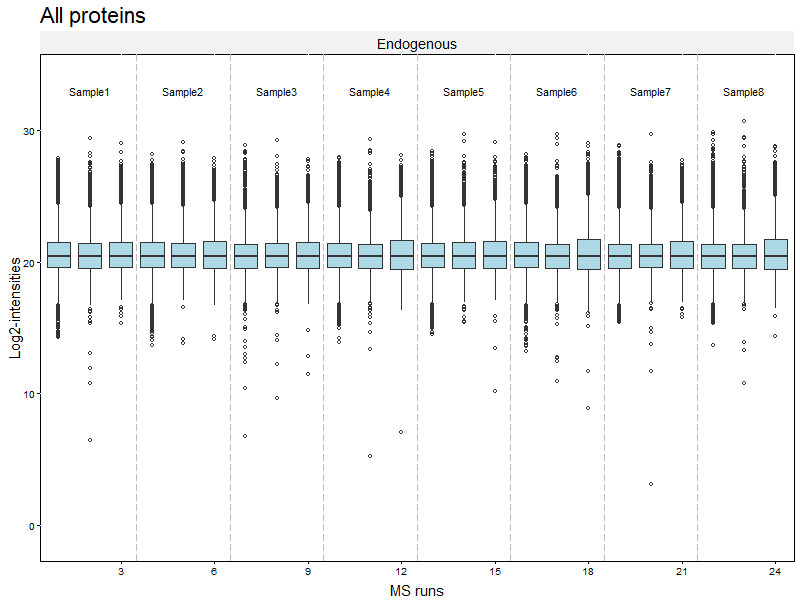

In [29]:
%%R -w 800 -h 600
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append('allonly', tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

[1] "sp|Q5JVX7|CA141_HUMAN"
  |========================================                              |  57%


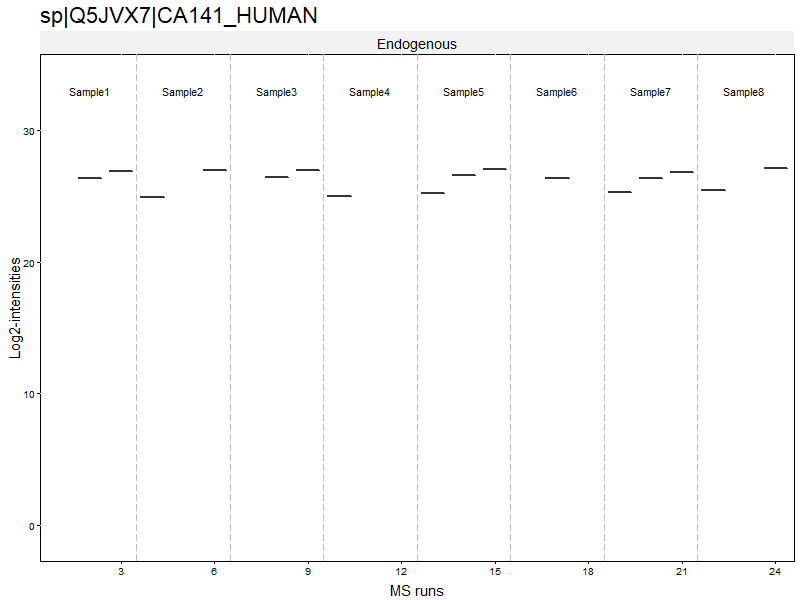

In [30]:
%%R -w 800 -h 600

Protein.Expression2 <- Protein.Expression[order(Protein.Expression$LogIntensities,decreasing = TRUE),]
protein_accession <- as.character(Protein.Expression2$Protein[1])
print(protein_accession)
tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="QCPlot",which.Protein=selector,width=10, height=5, address=FALSE)

#### background proteins: Intensity shoud be identical in all MSrun

  |======================================================================| 100%
  |======================================================================| 100%


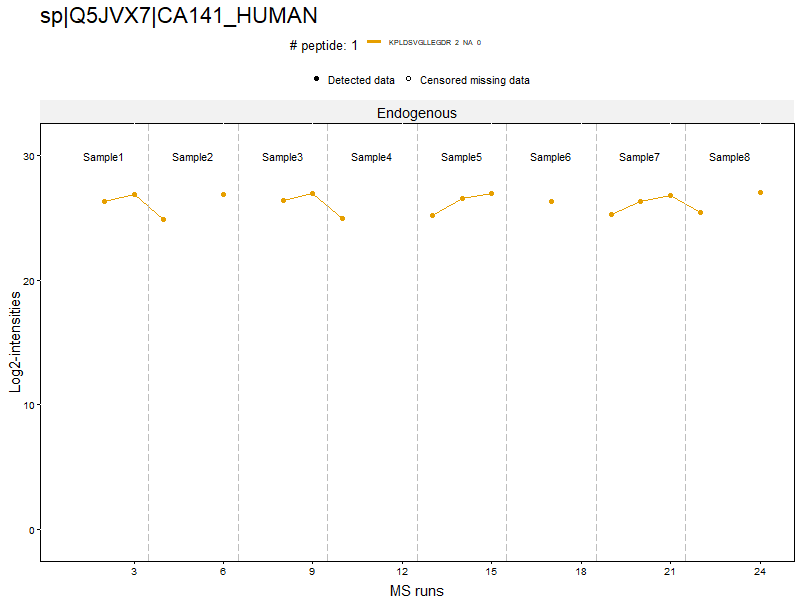

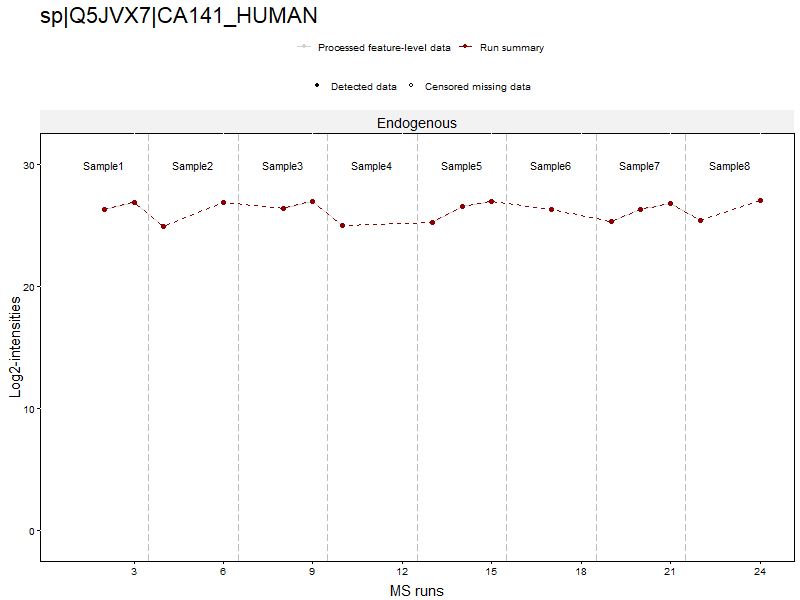

In [31]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append(protein_accession, tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ProfilePlot",which.Protein=selector,width=10, height=5, address=FALSE)

  |===========================                                           |  39%


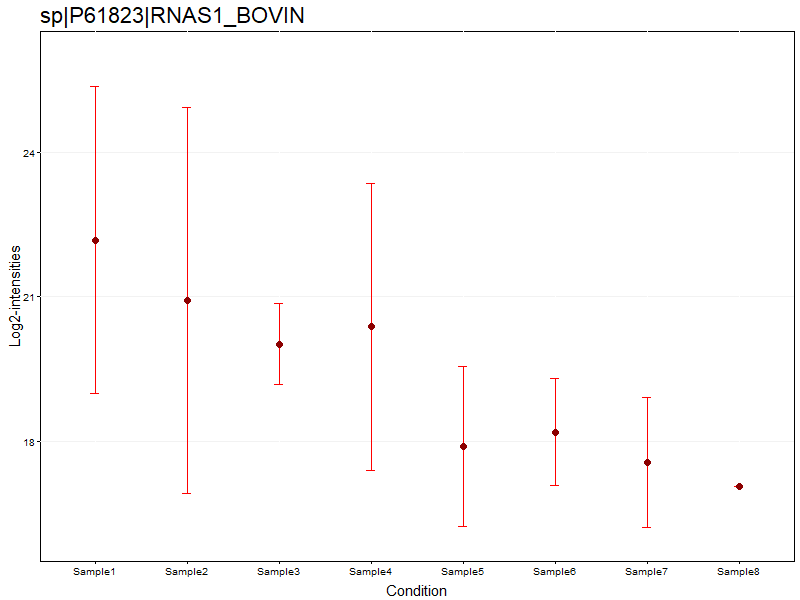

In [32]:
%%R -w 800 -h 600

tmp <- levels(quantms.proposed$ProcessedData$PROTEIN)
selector <- append("sp|P61823|RNAS1_BOVIN", tmp, 1)
dataProcessPlots(data = quantms.proposed, type="ConditionPlot",which.Protein=selector,width=10, height=5, address=FALSE)

In [33]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(groups)
comparison_matrix = c(0,0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,-1,-1,
                      0,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,-1,0,1,
                      0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,-1,0,0,1,1,0,
                     0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,-1,0,0,0,1,1,1,0,0,0,
                     0,0,-1,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,
                     0,-1,0,0,0,0,0,-1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,
                     -1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
comparison <- matrix(comparison_matrix, nrow=28)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- c("8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1")
print(comparison)

[1] "Sample1" "Sample2" "Sample3" "Sample4" "Sample5" "Sample6" "Sample7"
[8] "Sample8"
     Sample1 Sample2 Sample3 Sample4 Sample5 Sample6 Sample7 Sample8
8vs7       0       0       0       0       0       0      -1       1
8vs6       0       0       0       0       0      -1       0       1
8vs5       0       0       0       0      -1       0       0       1
8vs4       0       0       0      -1       0       0       0       1
8vs3       0       0      -1       0       0       0       0       1
8vs2       0      -1       0       0       0       0       0       1
8vs1      -1       0       0       0       0       0       0       1
7vs6       0       0       0       0       0      -1       1       0
7vs5       0       0       0       0      -1       0       1       0
7vs4       0       0       0      -1       0       0       1       0
7vs3       0       0      -1       0       0       0       1       0
7vs2       0      -1       0       0       0       0       1       0
7vs1      -1   

In [34]:
%%R

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)
write.csv(ResultComparison$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2021-12-11 19:21:28]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2021-12-11 19:22:12]  == Comparisons for all proteins are done.


### Measure Accuracy of protein quantification

#### Since the aim of most proteomcis studies is to analyze differential protein expression by revealing significant quantitative differences between complex proteomes, protein quantificaiton and ratio accurancy in pairwise comparisons are important factos to consider. Therefore calculated the log2FC olf protein intensities for each possible pair of the 5 sample testded (a total of 28 pairwise comparisons)

#### Computing the error between the experimental FC and expected FC. There are two metrcis including MAPE and MSE. The former is a relative error. The latter is a absolute error.

#### MAPE (Mean absolute percentage error) of detected UPS1 protein concentrations relative to the corresponding know concentrations for 36 paired comparisions. MAPE(%) = 1/N * (expected FC - experimental FC / expected FC) * 100. N=number of quantified spiked-in proteins

In [35]:
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
0,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs7,inf,NaN,NaN,NaN,NaN,0.0,oneConditionMissing,0.833333,0.0
1,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs6,-0.315094,NaN,NaN,0.0,NaN,NaN,NaN,0.666667,0.0
2,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs5,-0.172107,NaN,NaN,0.0,NaN,NaN,NaN,0.666667,0.0
3,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs4,-0.104771,NaN,NaN,0.0,NaN,NaN,NaN,0.666667,0.0
4,sp|A0A024RBG1|NUD4B_HUMAN;sp|Q9NZJ9|NUDT4_HUMAN,8vs3,inf,NaN,NaN,NaN,NaN,0.0,oneConditionMissing,0.833333,0.0


####  Most of MAPE values are low. For the comparison of lowest concentrations (2vs1) , the MAPE is 246.06. Such discrepancies in the errors might be due to the inability to distinguish between signal and noise(background) at lowest analyte concentrations.

[96.98903483758906, 61.61008008420961, 25.906598739035513, 10.308829551163374, 3.6998575522704655, 5.400287182973009, 8.757622583306825, 59.50399071389282, 21.281565300174165, 10.051861415832429, 6.6747180529272745, 1.3026203617338474, 9.93305365972245, 37.13286029810093, 4.962492822881262, -4.232889556516087, -3.855987006213477, 3.1370918242765935, 14.457881467071603, 5.773538036328443, -0.5442388984575883, 7.638360999744359, 122.44309001887012, 22.958716953152027, 78.05064222554718, 111.42057461210857, 50.836149535409454, 246.06779915483327]


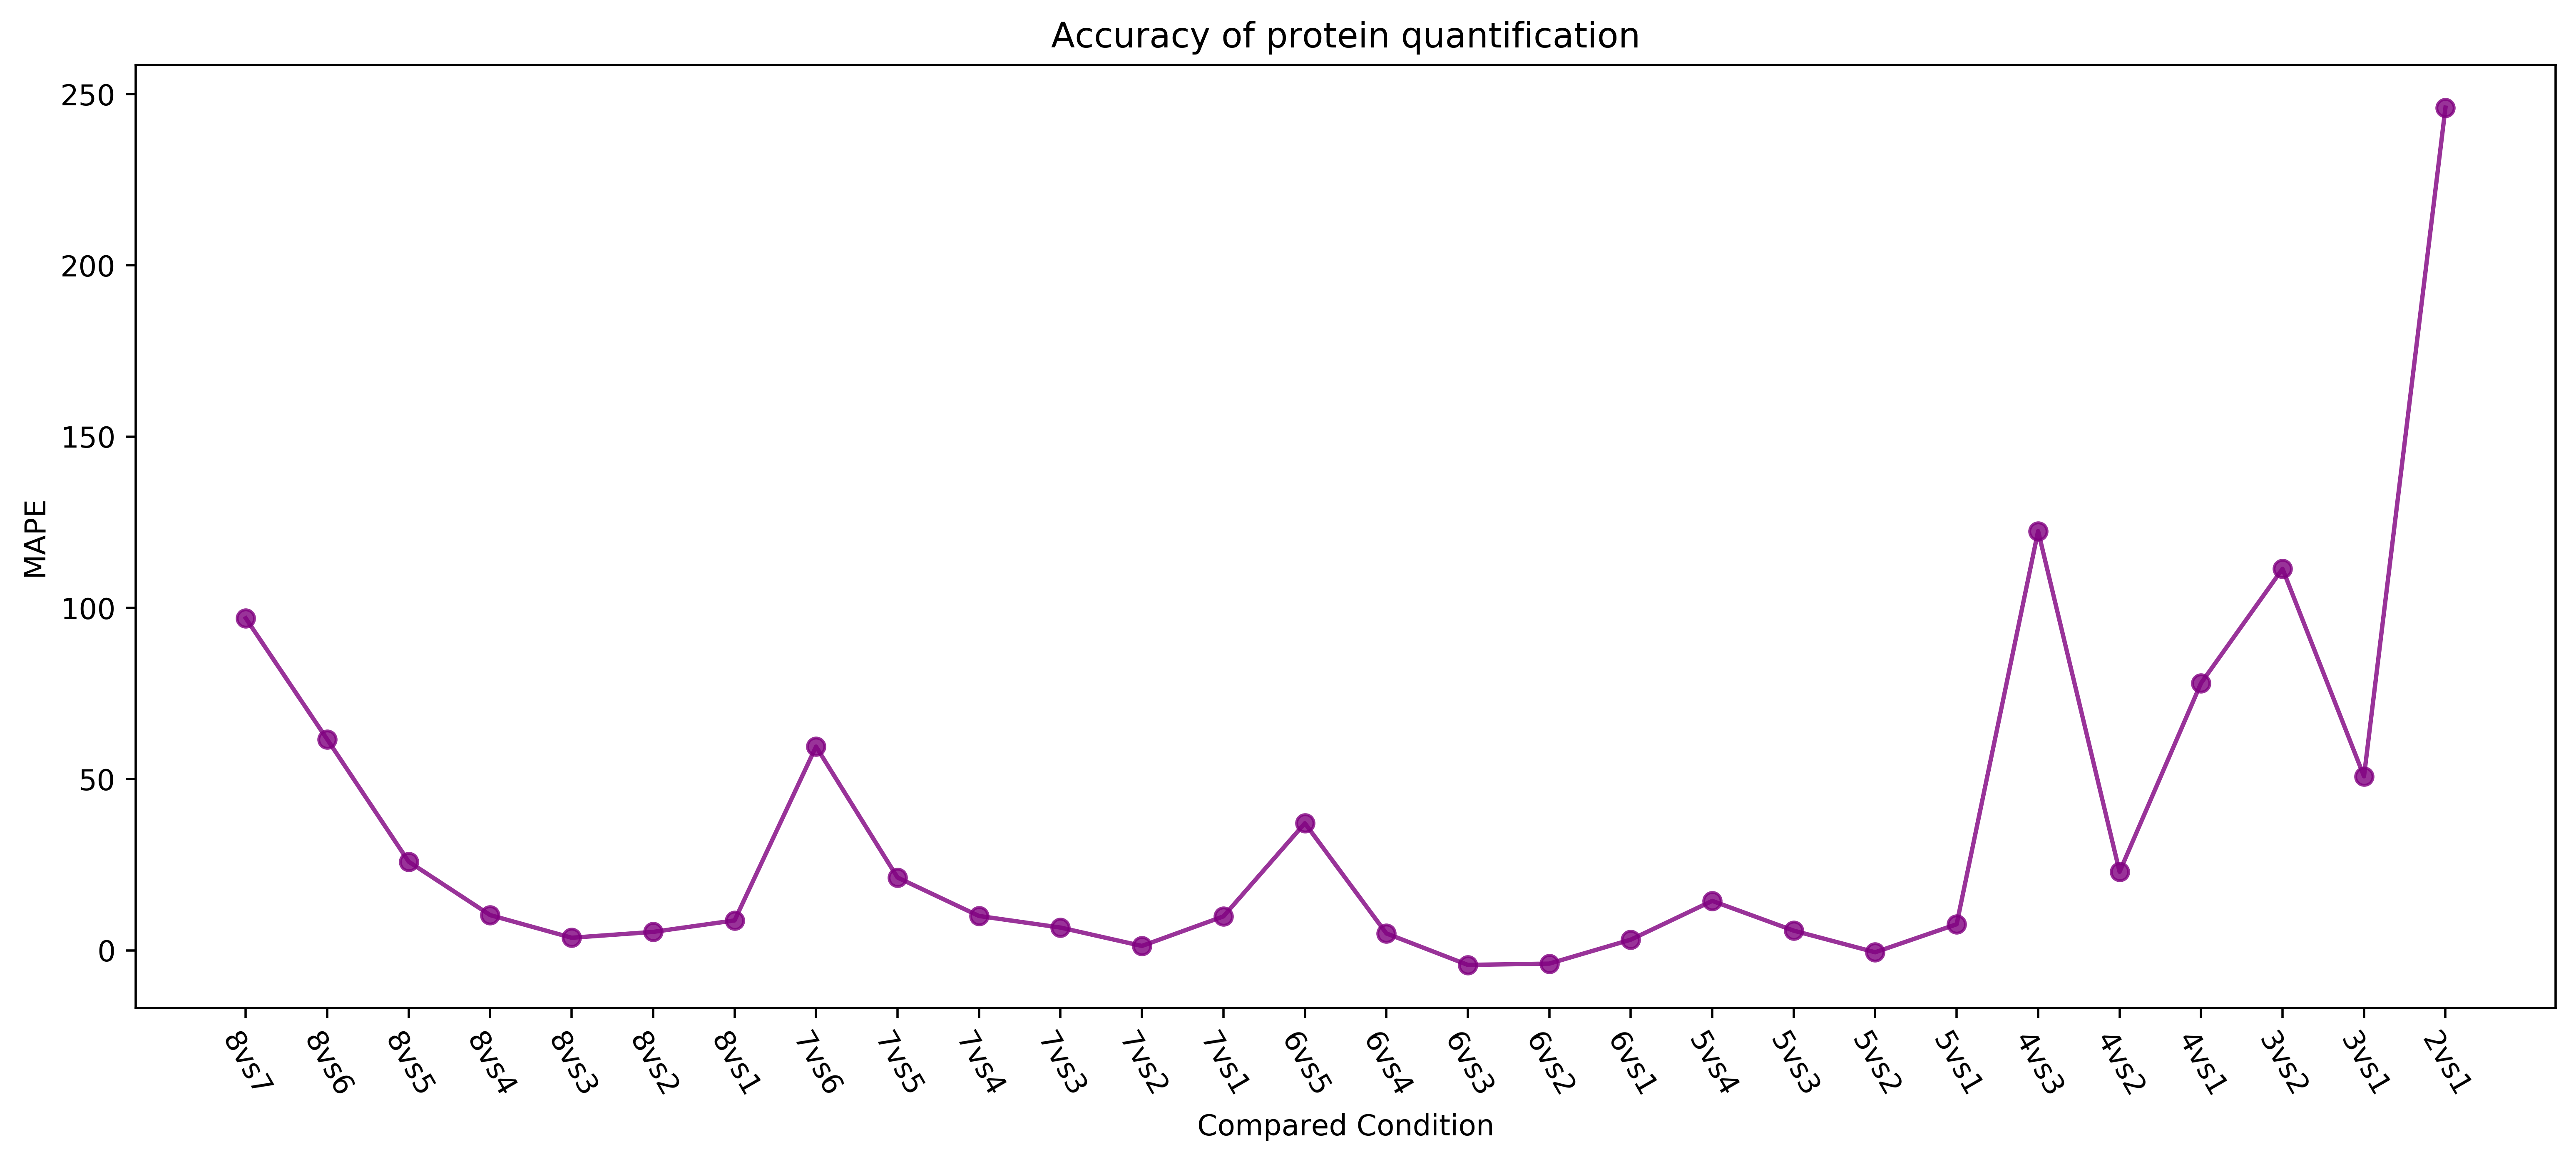

In [36]:
# calculate MAPE
import math
Master_Mix1 = ['sp|P02754|LACB_BOVIN', 'sp|P80025|PERL_BOVIN', 'sp|P00921|CAH2_BOVIN', 'sp|P00366|DHE3_BOVIN', 'sp|P02662|CASA1_BOVIN']
Master_Mix2 = ['sp|P61823|RNAS1_BOVIN', 'sp|P02789|TRFE_CHICK', 'sp|P12799|FIBG_BOVIN', 'sp|P02676|FIBB_BOVIN', 'sp|P02672|FIBA_BOVIN']
Master_Mix3 = ['sp|P02666|CASB_BOVIN', 'sp|P68082|MYG_HORSE']

Master_Mix1_Mass = {'1': 1.5, '2': 1.65, '3': 1.815, '4': 1.995, '5': 15, '6': 16.515, '7': 18.165, '8': 19.995}
Master_Mix2_Mass = {'1': 100, '2': 62.995, '3': 39.685, '4': 25, '5': 2, '6': 1.26, '7': 0.795, '8': 0.5}
Master_Mix3_Mass = {'1': 0.05, '2': 0.2, '3': 0.8, '4': 3.2, '5': 12.8, '6': 51.2, '7': 204.8, '8': 819.2}

MAPE = []
nonHuman_comp = compar_res[-compar_res['Protein'].str.contains("HUMAN")]
conditions = ["8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1"]

for condition in conditions:
    t = nonHuman_comp[nonHuman_comp['Label'] == condition]
    ape = []
    for protein in t['Protein']:
        if "Missing" in str(t[t['Protein'] == protein]['issue'].values[0]):
            continue
        if protein in Master_Mix1:
            expected_log2FC = np.log2(float(Master_Mix1_Mass[condition.split("vs")[0]]) / float(Master_Mix1_Mass[condition.split("vs")[1]]))
        elif protein in Master_Mix2:
            expected_log2FC = np.log2(float(Master_Mix2_Mass[condition.split("vs")[0]]) / float(Master_Mix2_Mass[condition.split("vs")[1]]))
        else:
            expected_log2FC = np.log2(float(Master_Mix3_Mass[condition.split("vs")[0]]) / float(Master_Mix3_Mass[condition.split("vs")[1]]))
        if expected_log2FC <0:
            
        experimental_log2FC = t[t['Protein'] == protein]['log2FC']
        ape.append(np.abs(expected_log2FC - experimental_log2FC) / expected_log2FC * 100)
        
    MAPE.append(np.mean(ape))

print(MAPE)
plt.figure(figsize=(15,6), dpi=500)
plt.plot(range(28), MAPE, 'ro-', color='purple', alpha=0.8, label='')
plt.xticks(range(28), conditions)
plt.title("Accuracy of protein quantification")
plt.xlabel("Compared Condition")
plt.ylabel("MAPE")
plt.xticks(rotation=300)
plt.show()

#### The MSE (expected logFC - experimental logFC)^2 of the logFC estimates in the all two-group comparisons. mean MSE: 8.94. Mean MSE of background proteins is very low: 0.54.

3.0749978338438573
0.17360728337138126
8.940605797483128
0.5402489188896802
14.079703128303722
1.2370073756852986


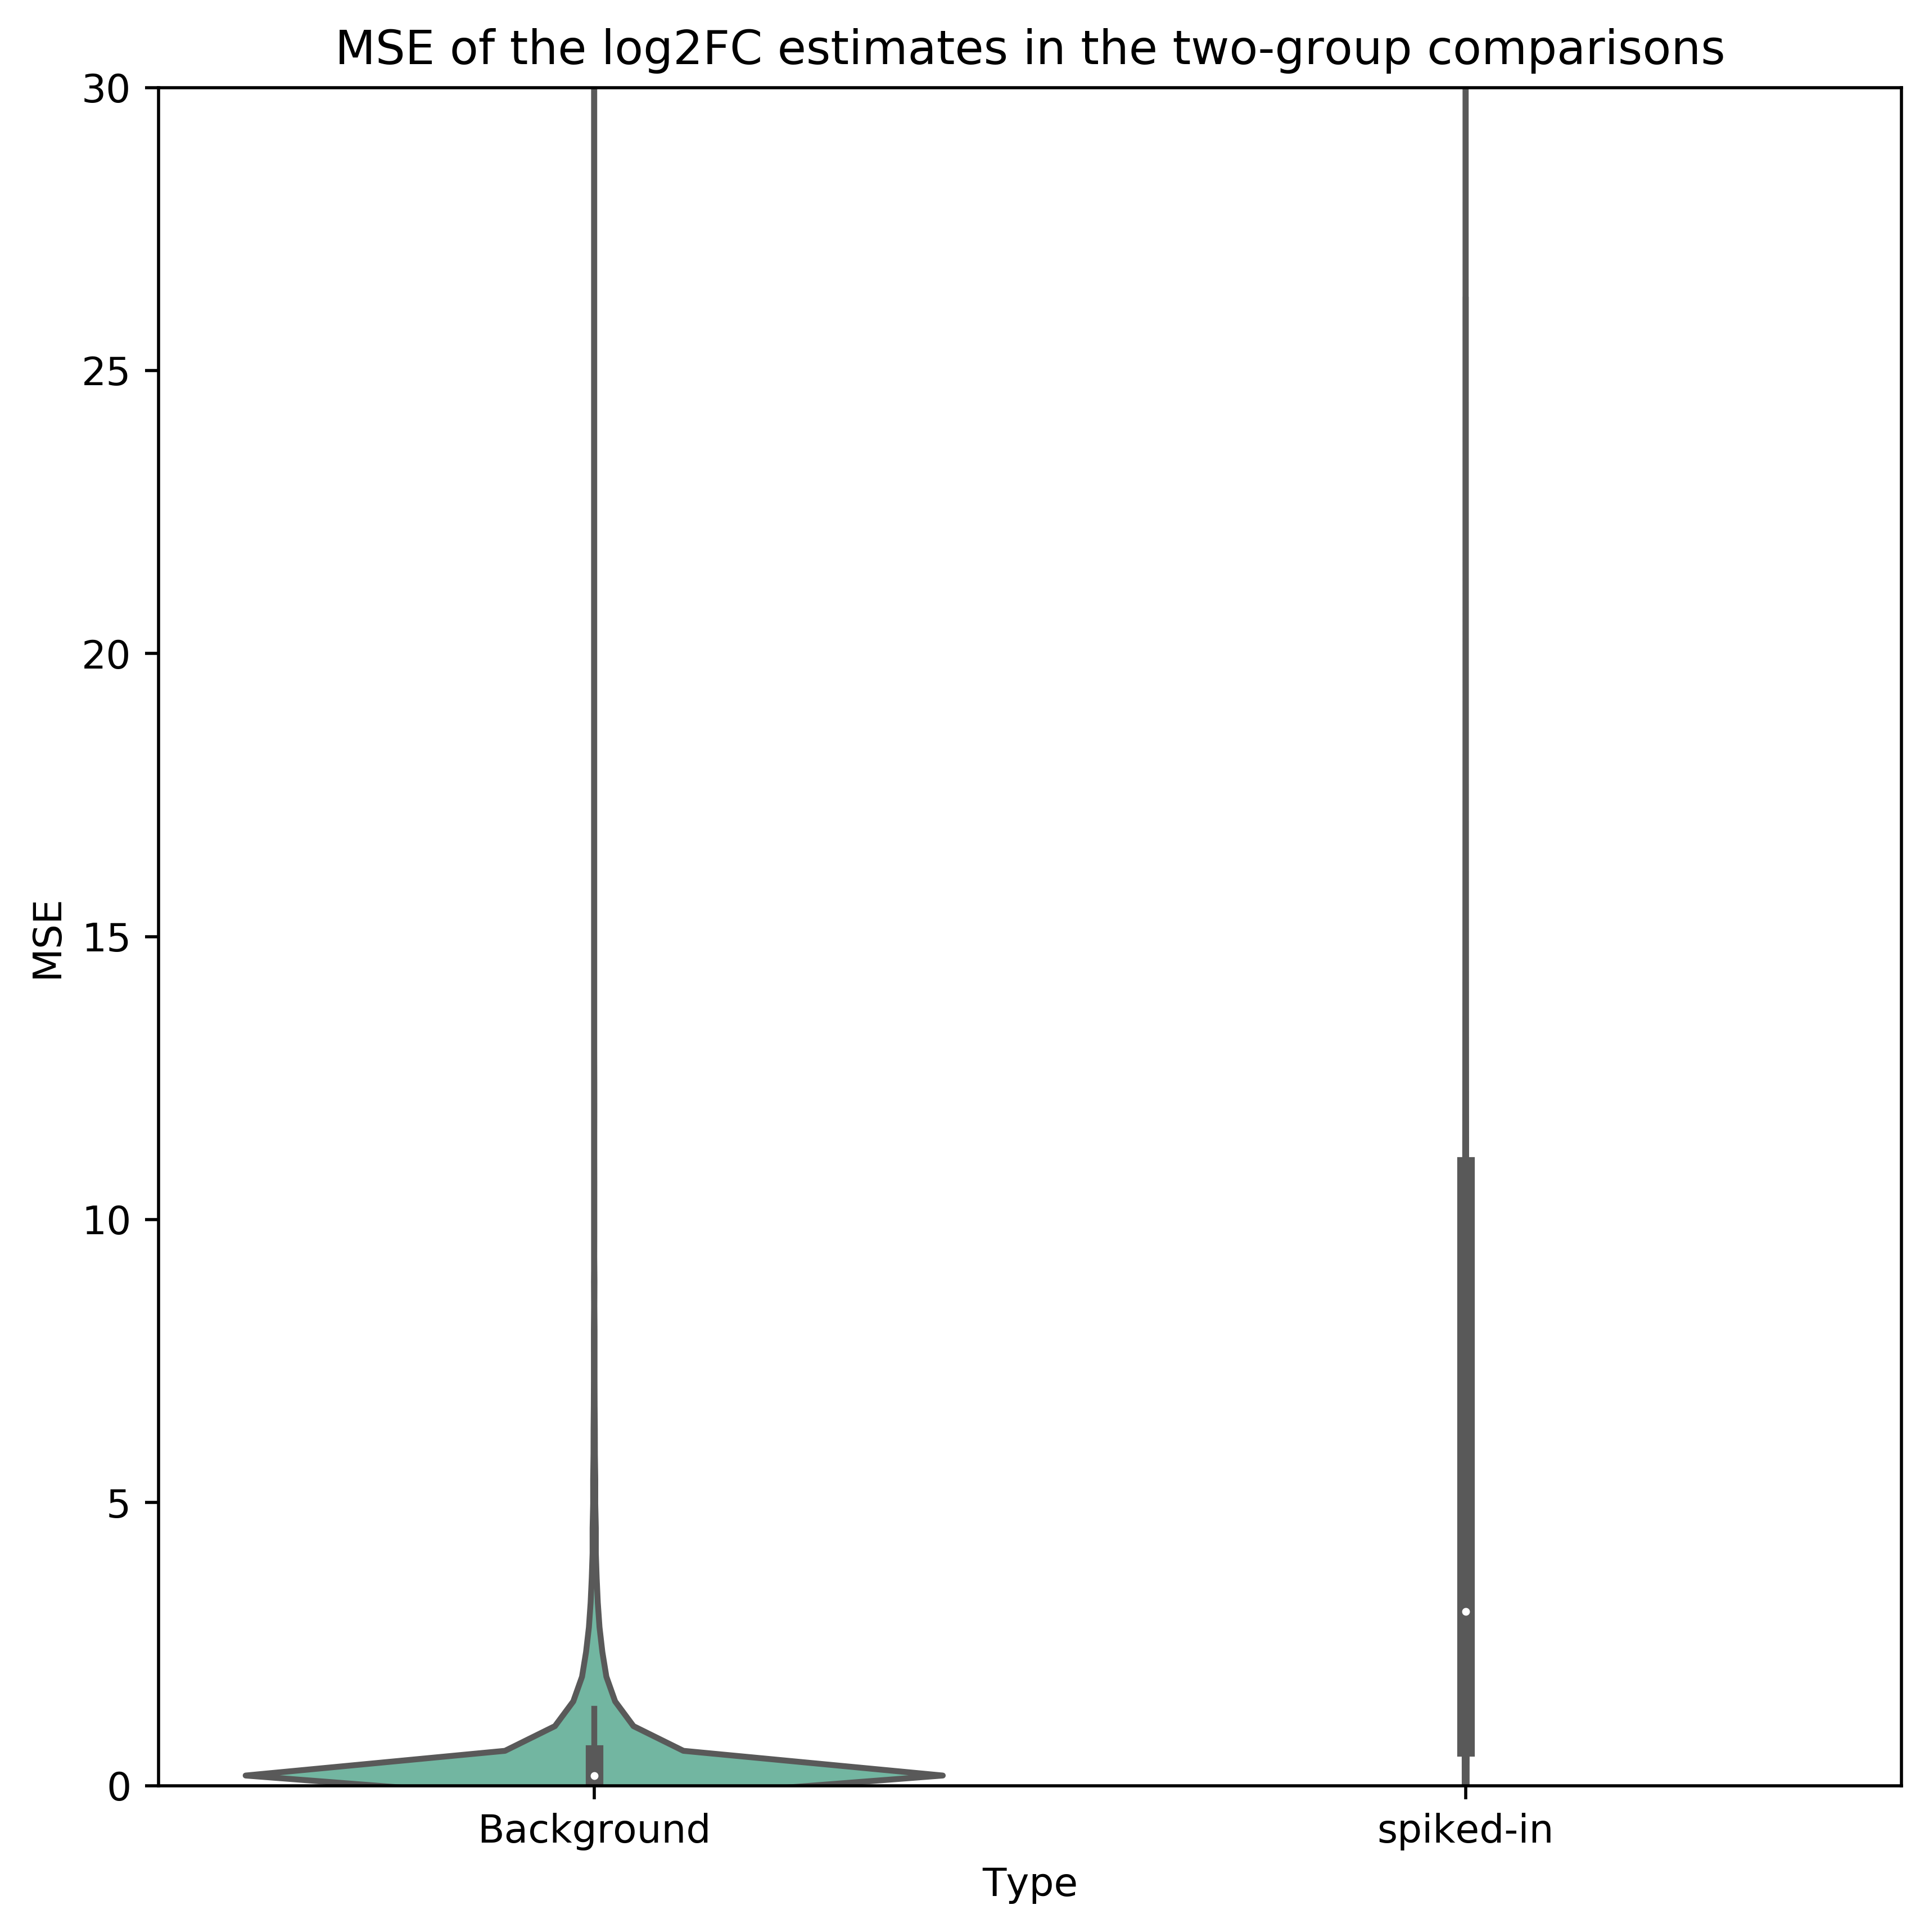

In [37]:
MSEs = pd.DataFrame(columns=["Type", "MSE"])
for _, row in compar_res.iterrows():
    if "Missing" in str(row['issue']):
        continue
    experimental_log2FC = row['log2FC']
    condition = row['Label']
    if "HUMAN" not in row['Protein']:
        datatype = "spiked-in"
        expected_log2FC = np.log2(float(condition.split("vs")[0]) / float(condition.split("vs")[1]))
    else:
        expected_log2FC = 0
        datatype = "Background"
    mse = (experimental_log2FC - expected_log2FC) ** 2
    MSEs = MSEs.append({'Type': datatype, "MSE": mse}, ignore_index=True)

plt.figure(figsize=(8,8), dpi=500)
plt.ylim(0, 30)
plt.title("MSE of the log2FC estimates in the two-group comparisons")
sns.violinplot(x = "Type", y="MSE", data=MSEs, scale= "count", palette="Set2")
print(np.median(MSEs[MSEs['Type'] == "spiked-in"]['MSE']))
print(np.median(MSEs[MSEs['Type'] != "spiked-in"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] == "spiked-in"]['MSE']))
print(np.mean(MSEs[MSEs['Type'] != "spiked-in"]['MSE']))
print(np.std(MSEs[MSEs['Type'] == "spiked-in"]['MSE']))
print(np.std(MSEs[MSEs['Type'] != "spiked-in"]['MSE']))
plt.show()

### Measure Sensitivity and specificity of the differential expression analysis

#### Proteins are typically chosen for follow-up experiment and validation based on the significance of their p-values or adj-pvalue/ q-value, especially for differential protein analysis. Thus, calculated the ROC curves based on adj-pvalue generated in the msstats.

#### Sensitivity (%) = 100 * TP / (TP+FN) and FDP (%) = 100 * FP / (FP+TP)；Specifity = TNR = TN / (TN + FN)

In [38]:
# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('(issue != issue) & (pvalue == pvalue)')
compar_res

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
28,sp|A0A075B767|PAL4H_HUMAN,8vs7,1.390983,1.924860,0.722641,4.0,0.509893,0.999034,NaN,0.166667,0.000000
31,sp|A0A075B767|PAL4H_HUMAN,8vs4,-0.320090,2.108579,-0.151804,4.0,0.886691,0.998845,NaN,0.333333,0.000000
33,sp|A0A075B767|PAL4H_HUMAN,8vs2,-0.609660,2.582471,-0.236076,4.0,0.824969,0.999693,NaN,0.500000,0.000000
34,sp|A0A075B767|PAL4H_HUMAN,8vs1,-0.527802,2.582471,-0.204379,4.0,0.848035,0.999662,NaN,0.500000,0.000000
37,sp|A0A075B767|PAL4H_HUMAN,7vs4,-1.711073,1.924860,-0.888933,4.0,0.424267,0.999982,NaN,0.166667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
95335,sp|Q9Y6Y8|S23IP_HUMAN,4vs2,0.194662,0.752946,0.258534,12.0,0.800376,0.999094,NaN,0.633333,0.466667
95336,sp|Q9Y6Y8|S23IP_HUMAN,4vs1,-0.520098,0.752946,-0.690751,12.0,0.502865,0.999520,NaN,0.600000,0.433333
95337,sp|Q9Y6Y8|S23IP_HUMAN,3vs2,0.365033,0.752946,0.484807,12.0,0.636543,0.999023,NaN,0.666667,0.500000
95338,sp|Q9Y6Y8|S23IP_HUMAN,3vs1,-0.349727,0.752946,-0.464478,12.0,0.650619,0.999519,NaN,0.633333,0.466667


#### ROC curve based on pvalue

#### AUC is 0.74. It's lower than other tools. see details in DOI: 10.1093/bib/bbx054. But pAUC should be more valuable

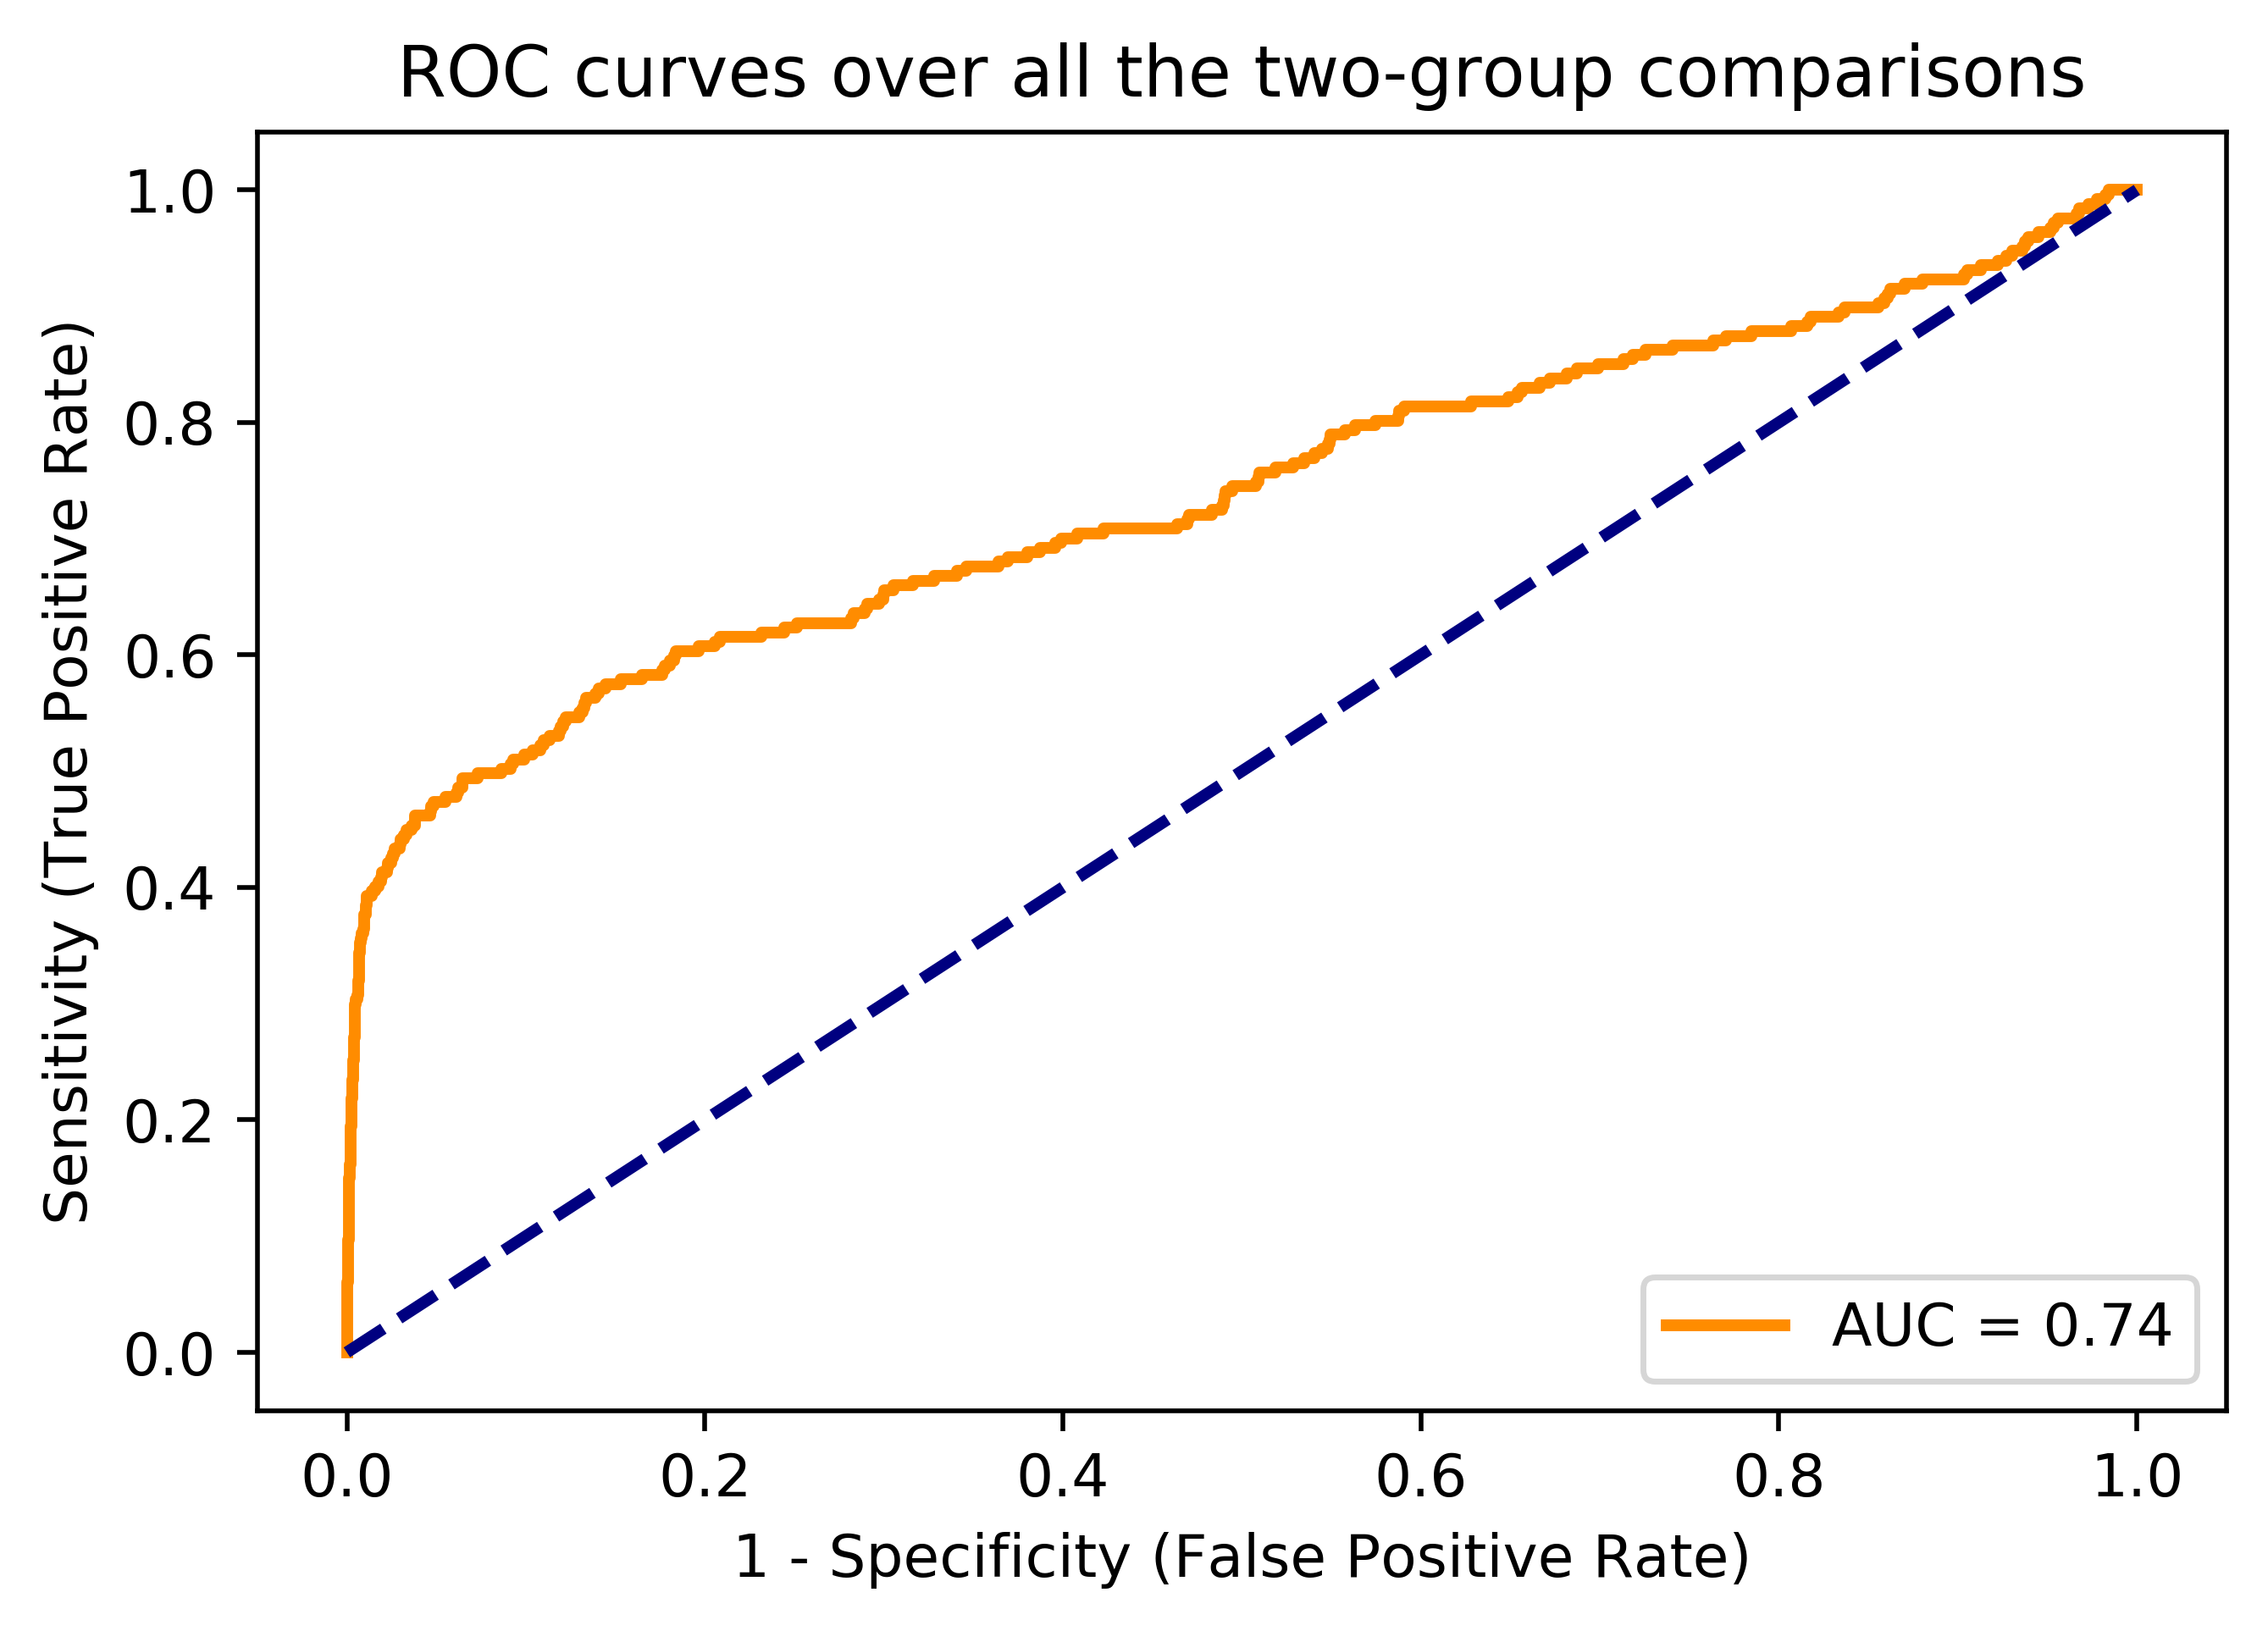

In [39]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['pvalue']
Master_Mix1 = ['sp|P02754|LACB_BOVIN', 'sp|P80025|PERL_BOVIN', 'sp|P00921|CAH2_BOVIN', 'sp|P00366|DHE3_BOVIN', 'sp|P02662|CASA1_BOVIN']
Master_Mix2 = ['sp|P61823|RNAS1_BOVIN', 'sp|P02789|TRFE_CHICK', 'sp|P12799|FIBG_BOVIN', 'sp|P02676|FIBB_BOVIN', 'sp|P02672|FIBA_BOVIN']
Master_Mix3 = ['sp|P02666|CASB_BOVIN', 'sp|P68082|MYG_HORSE']

m = Master_Mix1 + Master_Mix2 + Master_Mix3

compar_res['y'] = compar_res['Protein'].map(lambda x: (x in m and 1) or ("HUMAN" in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

#### ROC curve based on adj.pvalue. AUC=0.54

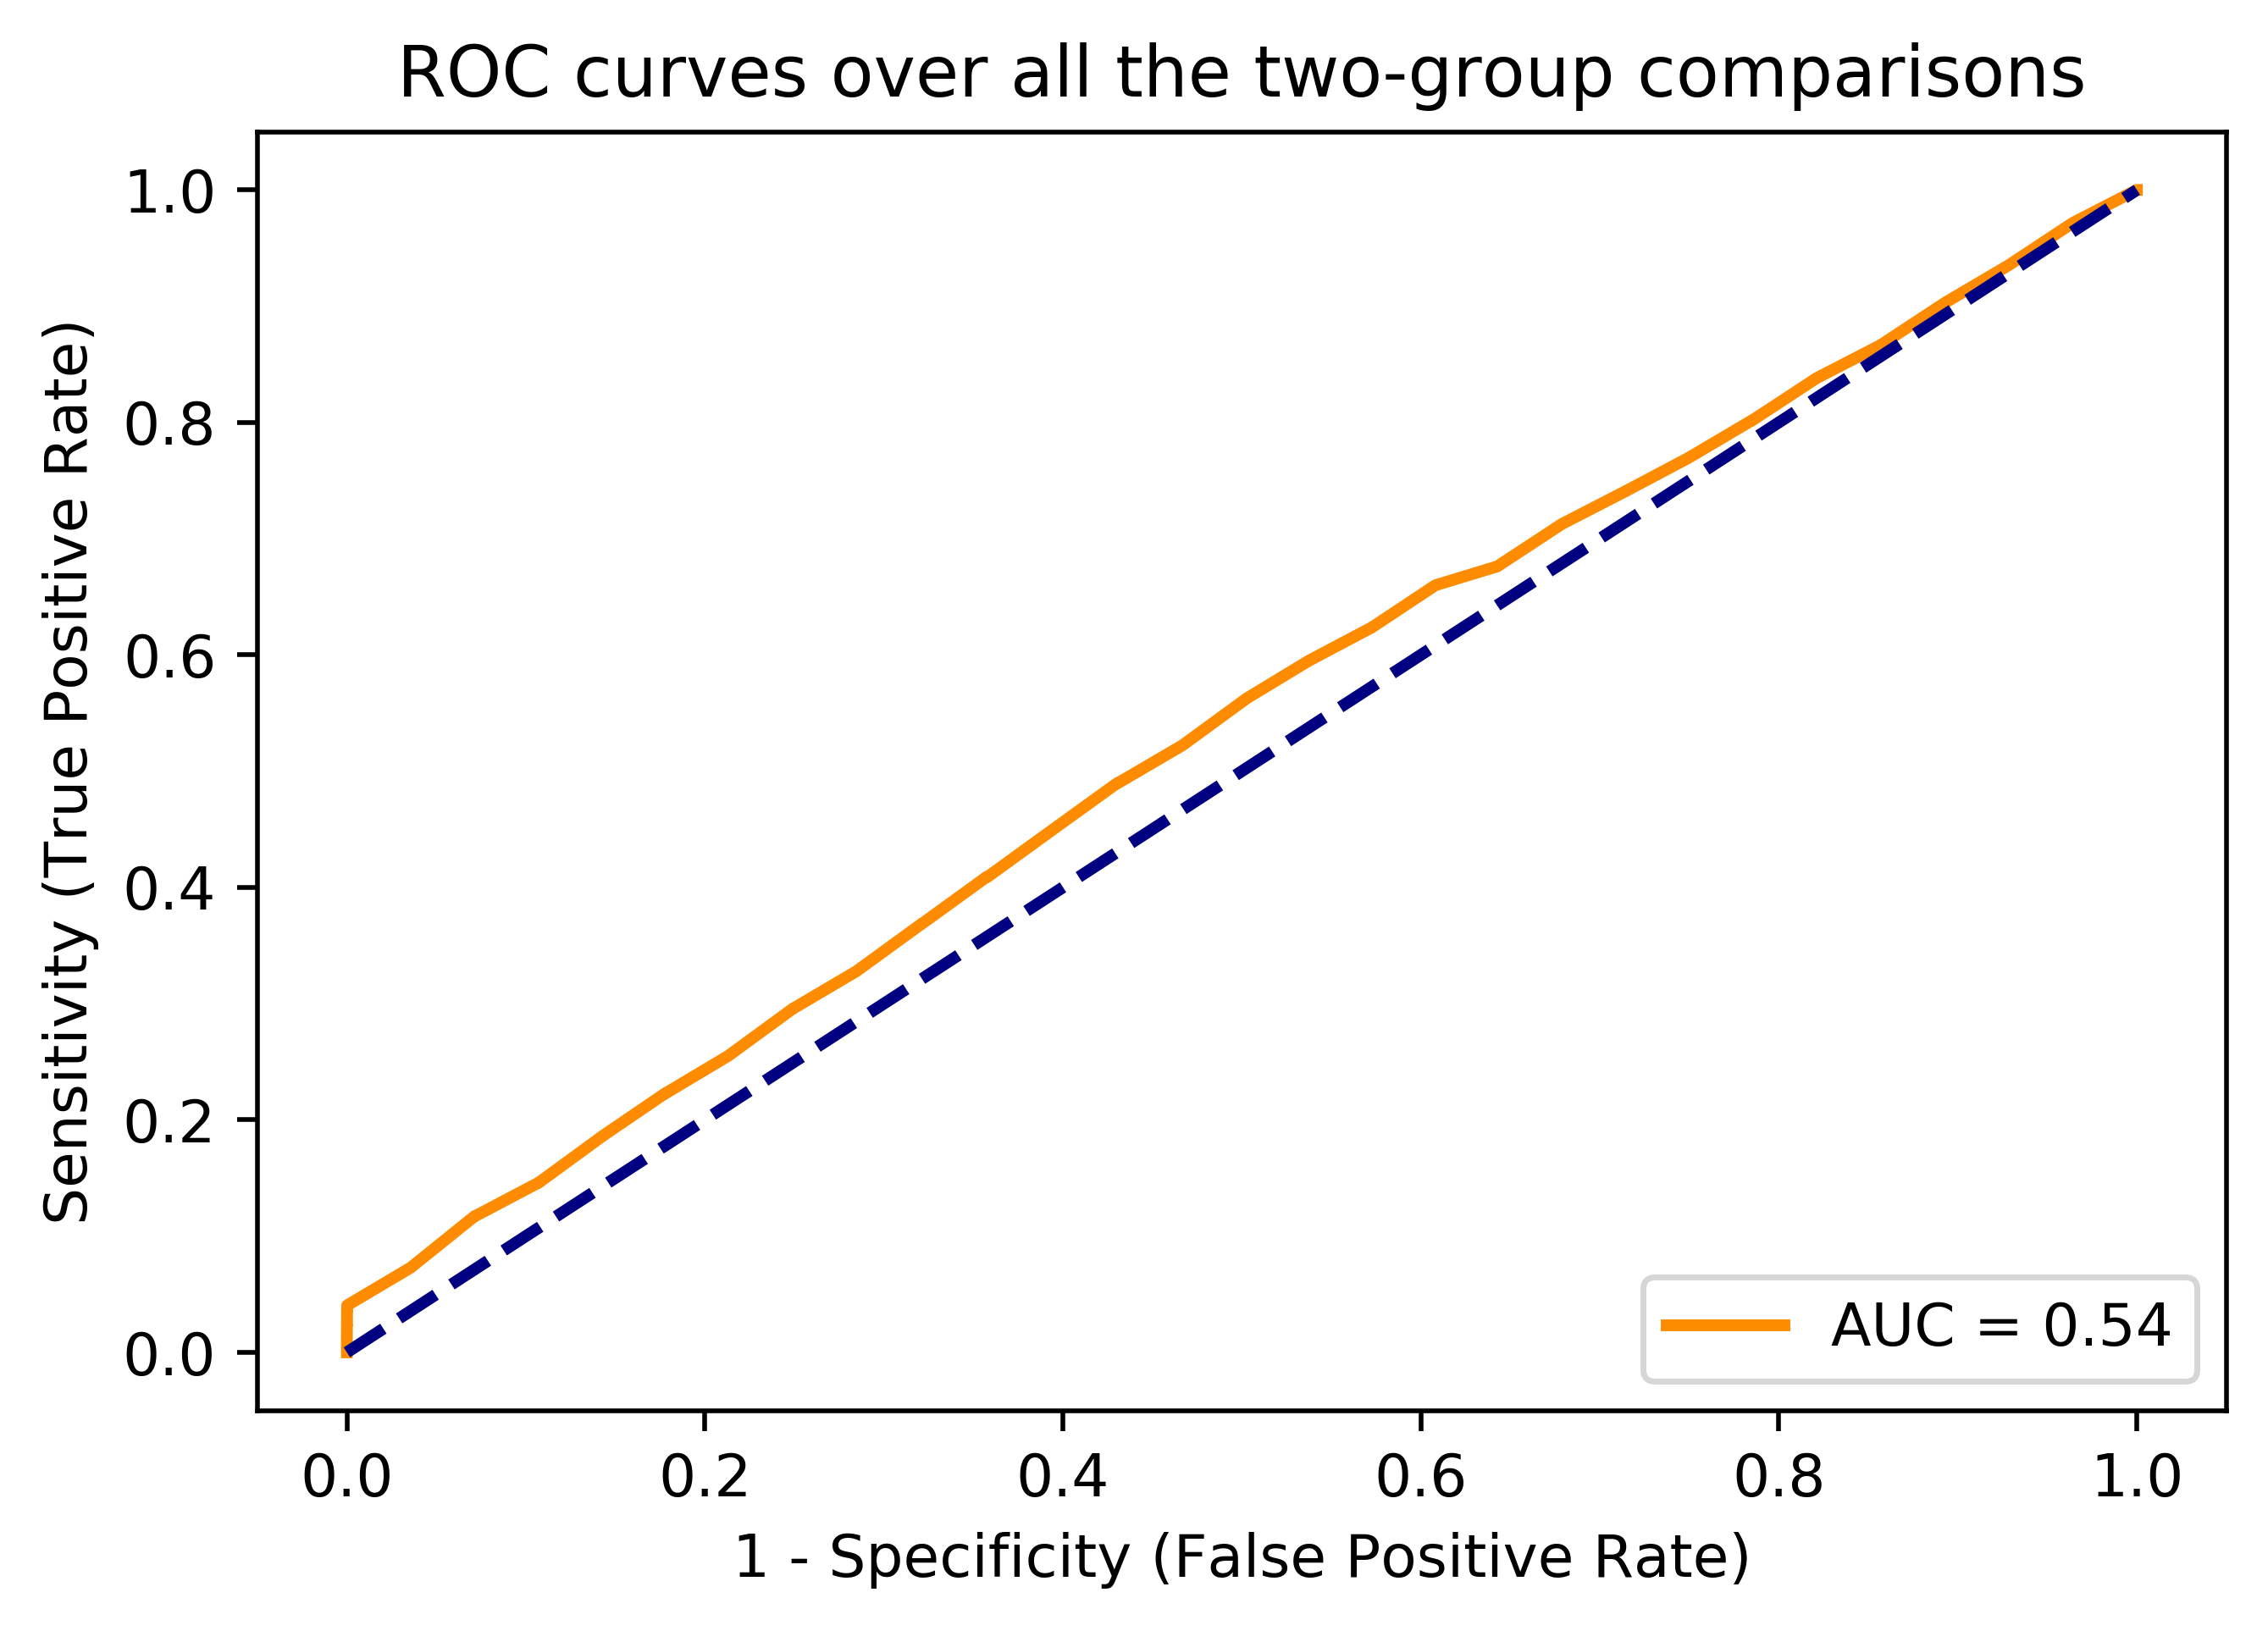

In [27]:
from sklearn import metrics

compar_res['value'] = 1 - compar_res['adj.pvalue']
Master_Mix1 = ['sp|P02754|LACB_BOVIN', 'sp|P80025|PERL_BOVIN', 'sp|P00921|CAH2_BOVIN', 'sp|P00366|DHE3_BOVIN', 'sp|P02662|CASA1_BOVIN']
Master_Mix2 = ['sp|P61823|RNAS1_BOVIN', 'sp|P02789|TRFE_CHICK', 'sp|P12799|FIBG_BOVIN', 'sp|P02676|FIBB_BOVIN', 'sp|P02672|FIBA_BOVIN']
Master_Mix3 = ['sp|P02666|CASB_BOVIN', 'sp|P68082|MYG_HORSE']

m = Master_Mix1 + Master_Mix2 + Master_Mix3

compar_res['y'] = compar_res['Protein'].map(lambda x: (x in m and 1) or ("HUMAN" in x and 0))

compar_res = compar_res.sort_values(by="value", ascending=False)
compar_res.head()

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curves over all the two-group comparisons")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

#### pAUC within each comparision based on pvalue

#### Calculating the total AUC seems arbitrary, because pvalue distribution may be difference between comparisons. And the differential expression proteins were detected in difference comparisons. Thus, pAUC metric is calculated

#### quantms delivering very high pAUCs in most of the two-group comparisons. Other low AUC may be mainly due to very low theoretical log2FC and low concentration.

Text(0.5, 1.0, 'pAUCs of each two-group comparison')

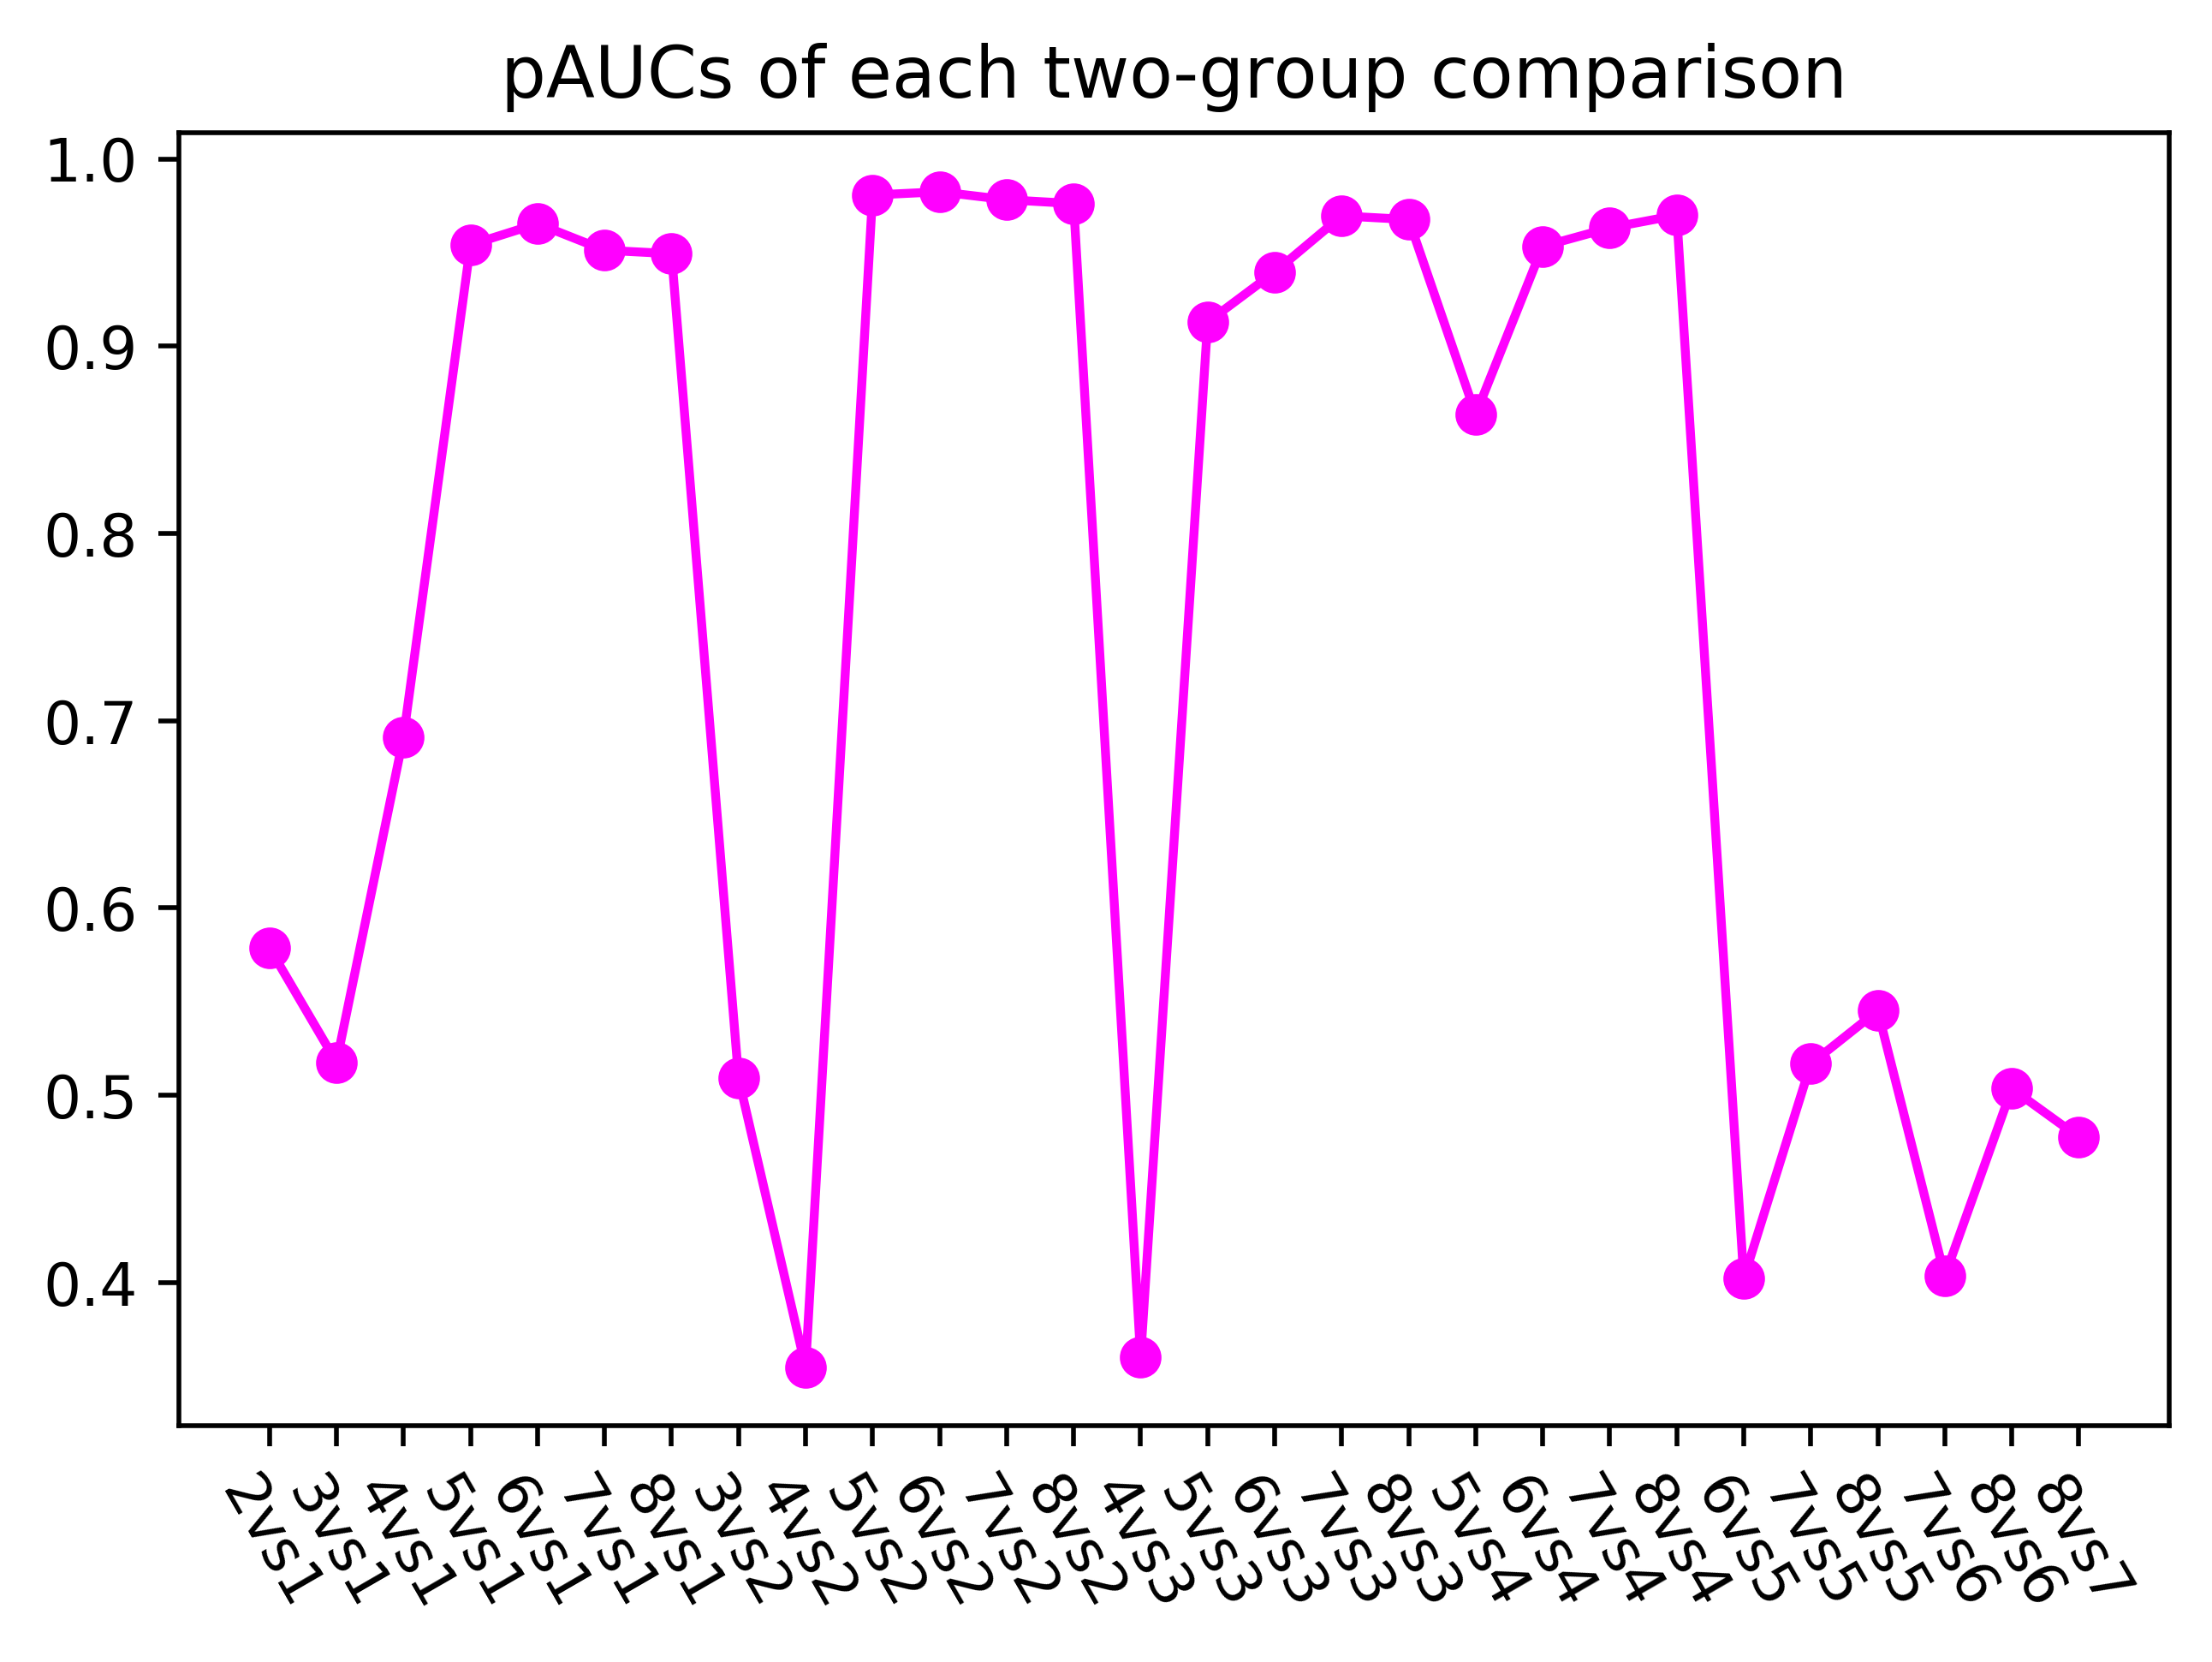

In [32]:
compar_res.head()

compar_res['value'] = 1 - compar_res['pvalue']
conditions = [ "2vs1", "3vs1", "4vs1", "5vs1", "6vs1", "7vs1", "8vs1", 
              "3vs2", "4vs2", "5vs2", "6vs2", "7vs2", "8vs2", "4vs3", "5vs3", "6vs3", "7vs3", "8vs3", 
              "5vs4", "6vs4", "7vs4", "8vs4", "6vs5", "7vs5", "8vs5", "7vs6", "8vs6", "8vs7"
             ]

paucs = []
for condition in conditions:
    comp_condition = compar_res[compar_res['Label'] == condition]
    fpr, tpr, thresholds = metrics.roc_curve(comp_condition['y'].tolist(), comp_condition['value'].tolist(), pos_label = 1)
    pauc = metrics.auc(fpr, tpr)
    paucs.append(pauc)

plt.figure(dpi=500)
plt.plot(range(28), paucs, 'ro-', color='magenta')
plt.xticks(range(28), conditions)
plt.xticks(rotation=300)

plt.title("pAUCs of each two-group comparison")

#### Ignore the following analysis for now

In [23]:
from sklearn import metrics
# calculate z-score: (FC-FC average) / FC std
FC_Average = np.mean(compar_res['log2FC'])
FC_Std = np.std(compar_res['log2FC'])

compar_res['Z-Score'] = compar_res.apply(lambda x: (x['log2FC'] - FC_Average) / FC_Std, axis=1)

conditions = ["8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1"]

data = pd.DataFrame(columns=['value', 'metrics', 'label', 'value2'])
for condition in conditions:
    group = compar_res[compar_res['Label'] == condition]
    differential_proteins = group[(group['adj.pvalue'] < 0.05) & (np.abs(group['Z-Score']) > 1.96)]
    FN = len(group[((group['adj.pvalue'] >= 0.05) | (np.abs(group['Z-Score']) <= 1.96 )) & (-group['Protein'].str.contains("HUMAN"))])
    TP = len(differential_proteins[-differential_proteins['Protein'].str.contains("HUMAN")]['Protein'])
    FP = len(differential_proteins[differential_proteins['Protein'].str.contains("HUMAN")]['Protein'])
    
    if TP + FP == 0:
        data = data.append({"value": 0, "metrics": "Sensitivity", "Label": condition, 'value2': 0}, ignore_index=True)
        data = data.append({"value": 0, "metrics": "FDP", "Label": condition, 'value2': 0}, ignore_index=True)
        continue
    Sensitivity = TP / (TP+FN) * 100
    FDP = FP / (FP + TP) * 100
    data = data.append({"value": Sensitivity, "metrics": "Sensitivity", "Label": condition, 'value2': Sensitivity}, ignore_index=True)
    data = data.append({"value": FDP, "metrics": "FDP", "Label": condition, 'value2': -FDP},ignore_index=True)
    
data.to_csv("./test1.csv", sep=',', index=False)

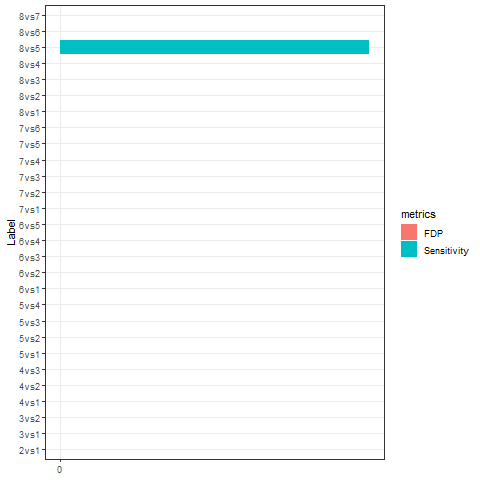

In [24]:
%%R 

library(ggplot2)
data = read.csv("test1.csv", sep=',',header = TRUE)
conditions = c("8vs7", "8vs6", "8vs5","8vs4","8vs3", "8vs2", "8vs1","7vs6", 
                          "7vs5", "7vs4", "7vs3", "7vs2","7vs1", "6vs5","6vs4","6vs3","6vs2","6vs1",
                          "5vs4","5vs3","5vs2","5vs1","4vs3","4vs2","4vs1","3vs2","3vs1","2vs1")

conditions = rev(conditions)
data$Label <- factor(data$Label,levels=conditions)

ggplot(data = data) + geom_col(aes(x = Label, y = value2, fill = metrics)) + 
   scale_y_continuous(breaks = seq(from = -100, to = 100,by = 20),labels = c(seq(100, 0, -20), seq(20, 100, 20))) + 
   coord_flip() + theme_bw() + ylab(NULL)

# ggsave("sensitivity.png", dpi = 500)